# Sailbuoy Kringla DCPS

This notebook takes care of the dpcs.txt file that is output from the Sailbuoy datalogger. 

Kringla was deployed in the Southern Ocean for the SO-CHIC project, analyzing surface characteristics in a couple of subregions. Settings for the DCPS were:
- **Basic output + beams**
- **Cell size** = 2 m
- **Cell spacing** = 2 m
- **Number of cells** = 40
- **Number of pings** = 150

We chose the above settings to have a good compromise between range, accuracy, and power consumption. The extra output allows us to do a rigorous QC  

And for the datalogger:
- **$LRMIN 15**

Minutes between samples. This was later (8 June) changed to 10 minutes.
- **$DCPS.MIN 3**  

Minutes that the sensor was on.
- **$DCPS.AVG 6**  

Number of cells to average and send over Iridium.
- **$DCPS.DEV -21**  

Local magnetic declination, this was added after 16 Feb, and then continuously updated based on latitude. Does not apply to the DCPS.txt.
- **$STRDL 300**  

Startup delay, 5 minutes. Was added 22 Feb to let the SB complete each tack, which could take 2 minutes. This was later (25 March) changed to 3 minutes. This does affect DCPS.txt as without it the SB -could- have had a tack while measuring, which affects the calculated speed and heading.
- **$DCPS.RC 4**  

Run counter. I.e., let the sensor open every 4th time the datalogger turns on. This was done 24th May to conserve battery. Does affect DCPS.txt since it controls how often the sensor samples. This was changed later (8 June) to 6, to comply with an increase in frequency to improve T/S sampling. It was also changed 3 July to 3, to increase sampling frequency to 30 minutes, and changed to 1 (10 minutes) on 8 July.




### Load packages and set some settings

In [2]:
%load_ext autoreload
%autoreload 1

import pandas as pd
import numpy as np
from collections import Counter
import datetime
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator, HourLocator
import gsw
import geomag
import matplotlib.dates as mdates
from cmocean import cm as cmo
import matplotlib as mpl
from tqdm.notebook import tqdm_notebook as tqdm
import sys

sys.path.append('/Volumes/MASSIVEUNIT/Work/SOCHIC_2022/sailbuoy_processing/code/')

%aimport dcps_tools
%aimport dcps_plotting

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 30}

mpl.rc('font', **font)

def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)


mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1

### Load the data

In [3]:
path = '/Volumes/MASSIVEUNIT/Work/SailBuoy Internship/Data/2022_SOCHIC_Full/DCPS.TXT'
desc = 'DCPS from SB Kringla 2022'
ds = dcps_tools.load_dcps(path,desc)

ds = dcps_tools.drop_bad_vars(ds)           # Dropping variables starting with '*'. Asked Aanderaa about this, waiting for reply.
ds = dcps_tools.add_attrs(ds)               # Adding correct attributes/metadata
ds = dcps_tools.calc_heading_speed(ds)      # Calculates the horizontal heading and speed of the Sailbuoy during each sample period
ds = dcps_tools.corr_mag_dec(ds)            # Correcting the measured horizontal speed and direction for magnetic declination
ds = dcps_tools.corr_speed(ds)              # Correcting the measured horizontal speed and direction for Sailbuoy's GPS movements
ds = dcps_tools.add_coords(ds)              # Adding lat, lon, and depth as coordinates
ds = dcps_tools.update_attrs(ds)            # Updating attributes/metadata for the calculated variables

Checking lines in input file:   0%|          | 0/701415 [00:00<?, ?it/s]

14555 good measurements found in input file
67 corrupt measurements found in input file
4 measurements without GPS fix found in input file

ADCP data comprised of 40 cells



Creating dataset:   0%|          | 0/701415 [00:00<?, ?it/s]

Loaded 14555 good measurements to dataset.
Discarded 67 corrupt measurements.
Discarded 4 measurements without GPS fix.
Dropped 20 variables starting with * from the dataset.
Updated names, units, and description for 45 variables
Calculating heading and speed of the SB...
Done!
Correcting for magnetic declination...
Done!
Correcting for GPS movements...
Done!
Correcting for GPS movements...
Done!
Added lat, lon, and depth as coordinates.
Added lat, lon, and depth as coordinates.
Updated names, units, and description for 10 variables.
Updated names, units, and description for 10 variables.


### Compare original data with corrections

Since the SB more often that not travel faster than the currents, it will reflect that in the measured current, since the output do not take it into account. A histogram of the velocity components, splitting up by the direction of travel will show this.

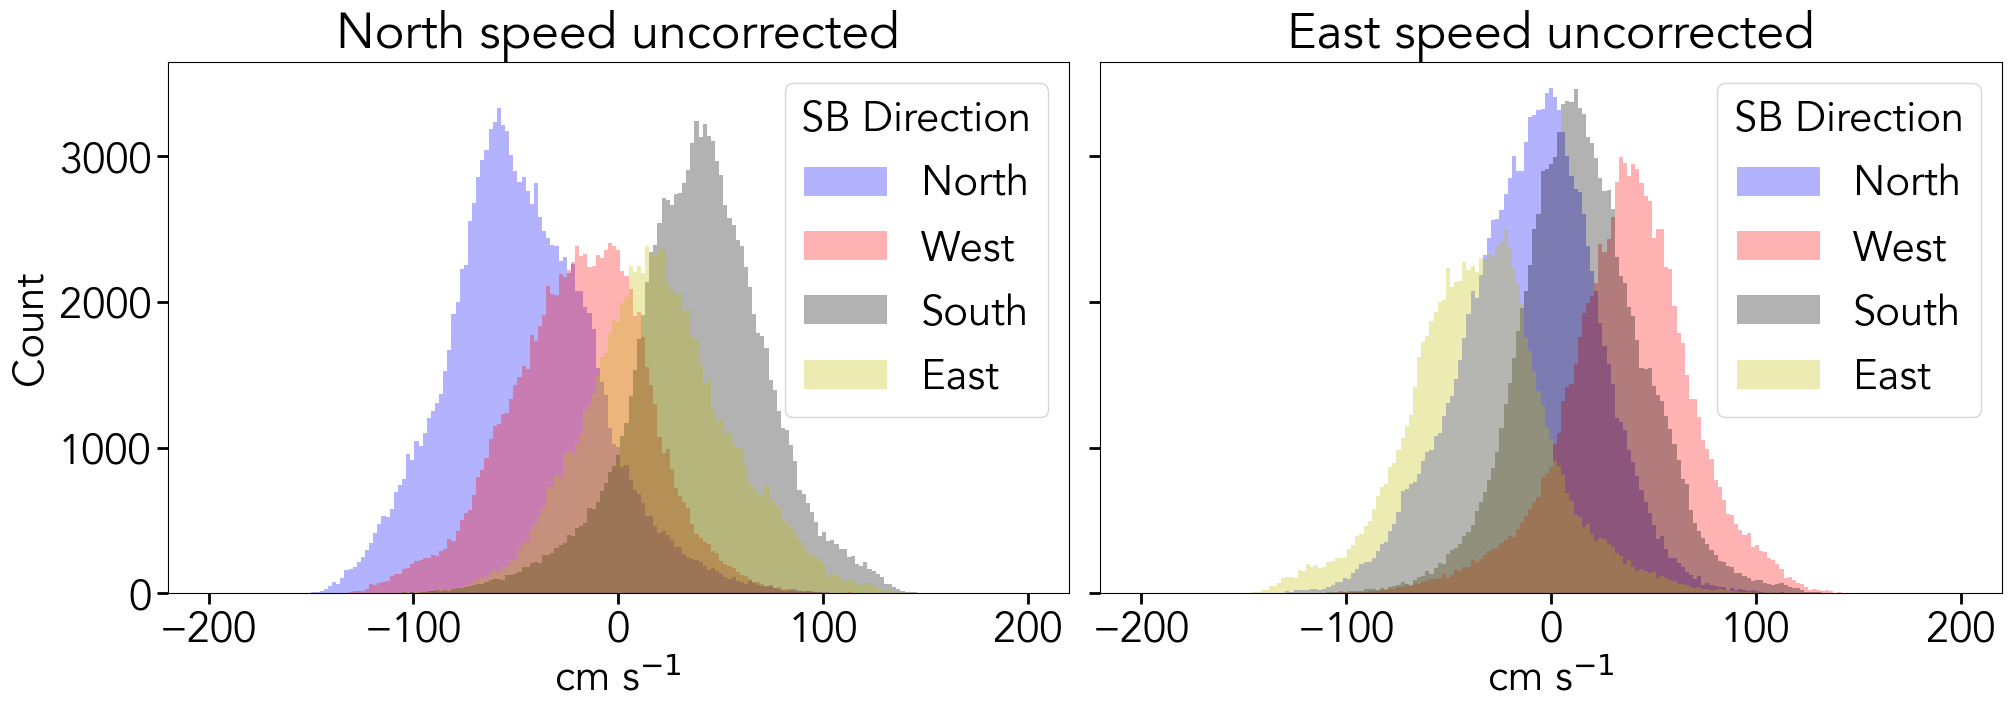

In [173]:
dcps_plotting.heading_dist(ds,200,'vel_north_raw','vel_east_raw','../figs/ne_raw_hist.png')

When the Sailbuoy was travelling north, the observed current trended south. Likewise for the other compass movements. Eastward travel saw a westward current, southward saw a northward current, and westward saw an eastward current. This is very expected, due to the sampling and lack of correction.

**Explained:** <br>
In an idealized scenario, an ocean devoid of currents, a moving SB would register current exactly 180° relative to its own movement. That is in the corrections above, we add the SB speed to the measured currents.

E.g., SB is travelling north at 1 m s$^{-1}$ over said calm ocean. The output from the sensor would be a 1 m s$^{-1}$ southward current. By starting with the measured value in the northern component, - 1 m s$^{-1}$, and adding the SB speed, + 1 m s$^{-1}$, we end up with 0 m s$^{-1}$, which is the actual current of the water in this example.


By correcting for magnetic declination and correcting for the instruments movements, we expect to see the same distribution, regardless of which direction the SB is travelling in. 

That's the theory at least, but does it work?

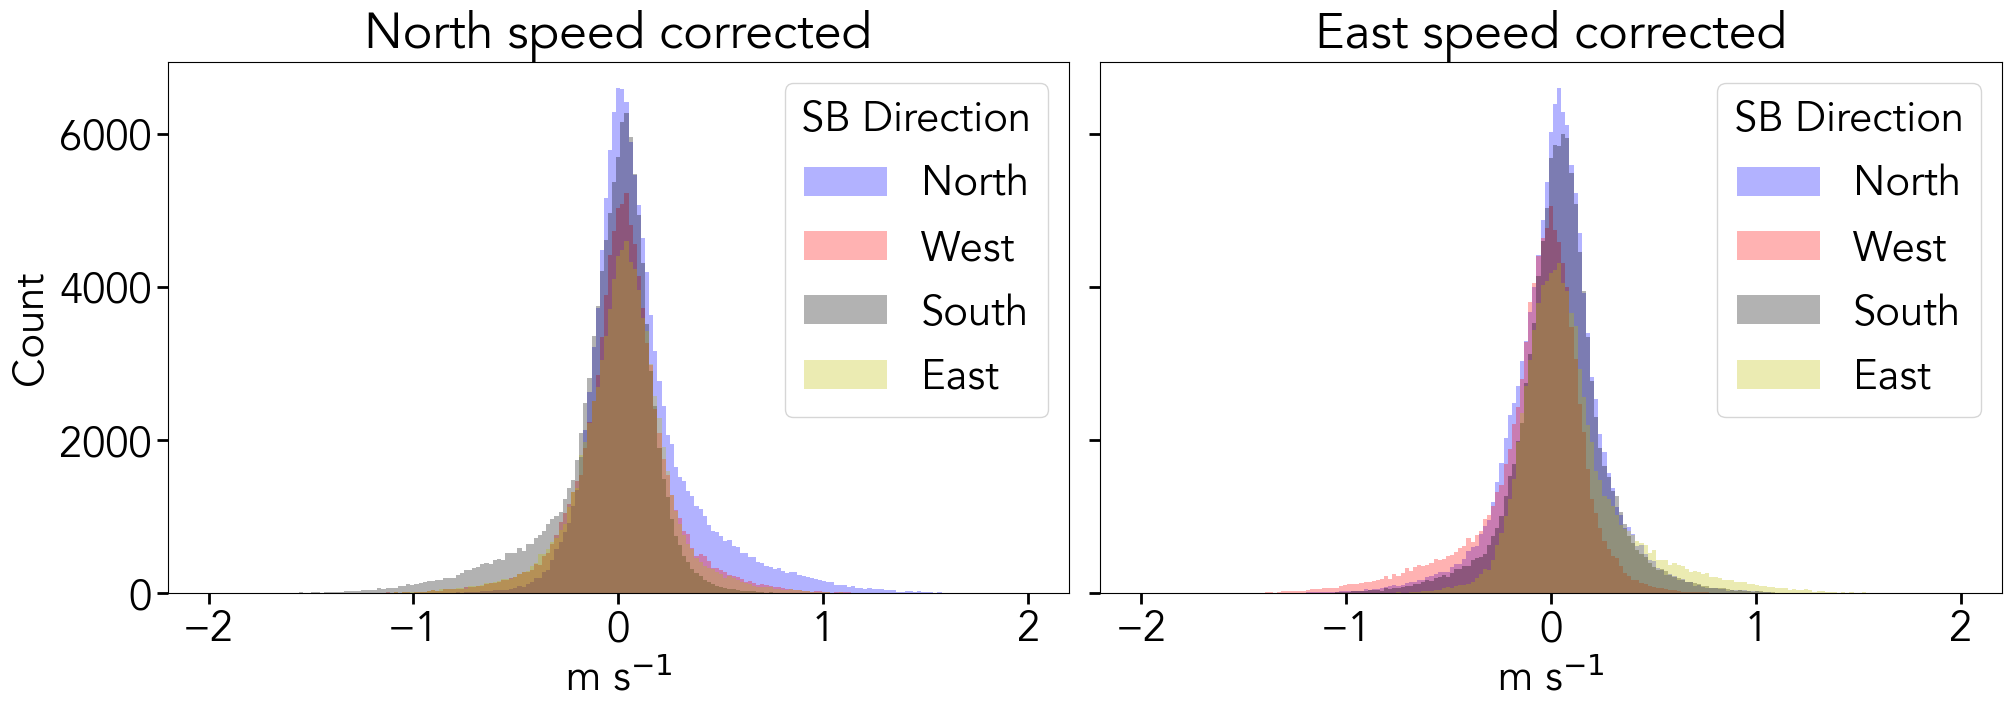

In [5]:
dcps_plotting.heading_dist(ds,2,'c_v_corr','c_u_corr','../figs/ne_qc_hist.png')

Corrections definitely looks like they have corrected the dataset in the right way. **Yay!**

There are still some bias I think in that the correction adds a bit too much, the fact that each direction are slightly skewed towards that direction. I think that this will be taken care of by further QC, since there are some (vertical) regions where the strenght is quite low, and therefor might report 0 m s$^{-1}$ currents, which will then be over estimated when adding the SB velocities.

Let's take a look at what the data looks like, we probably still need to do some more QC.

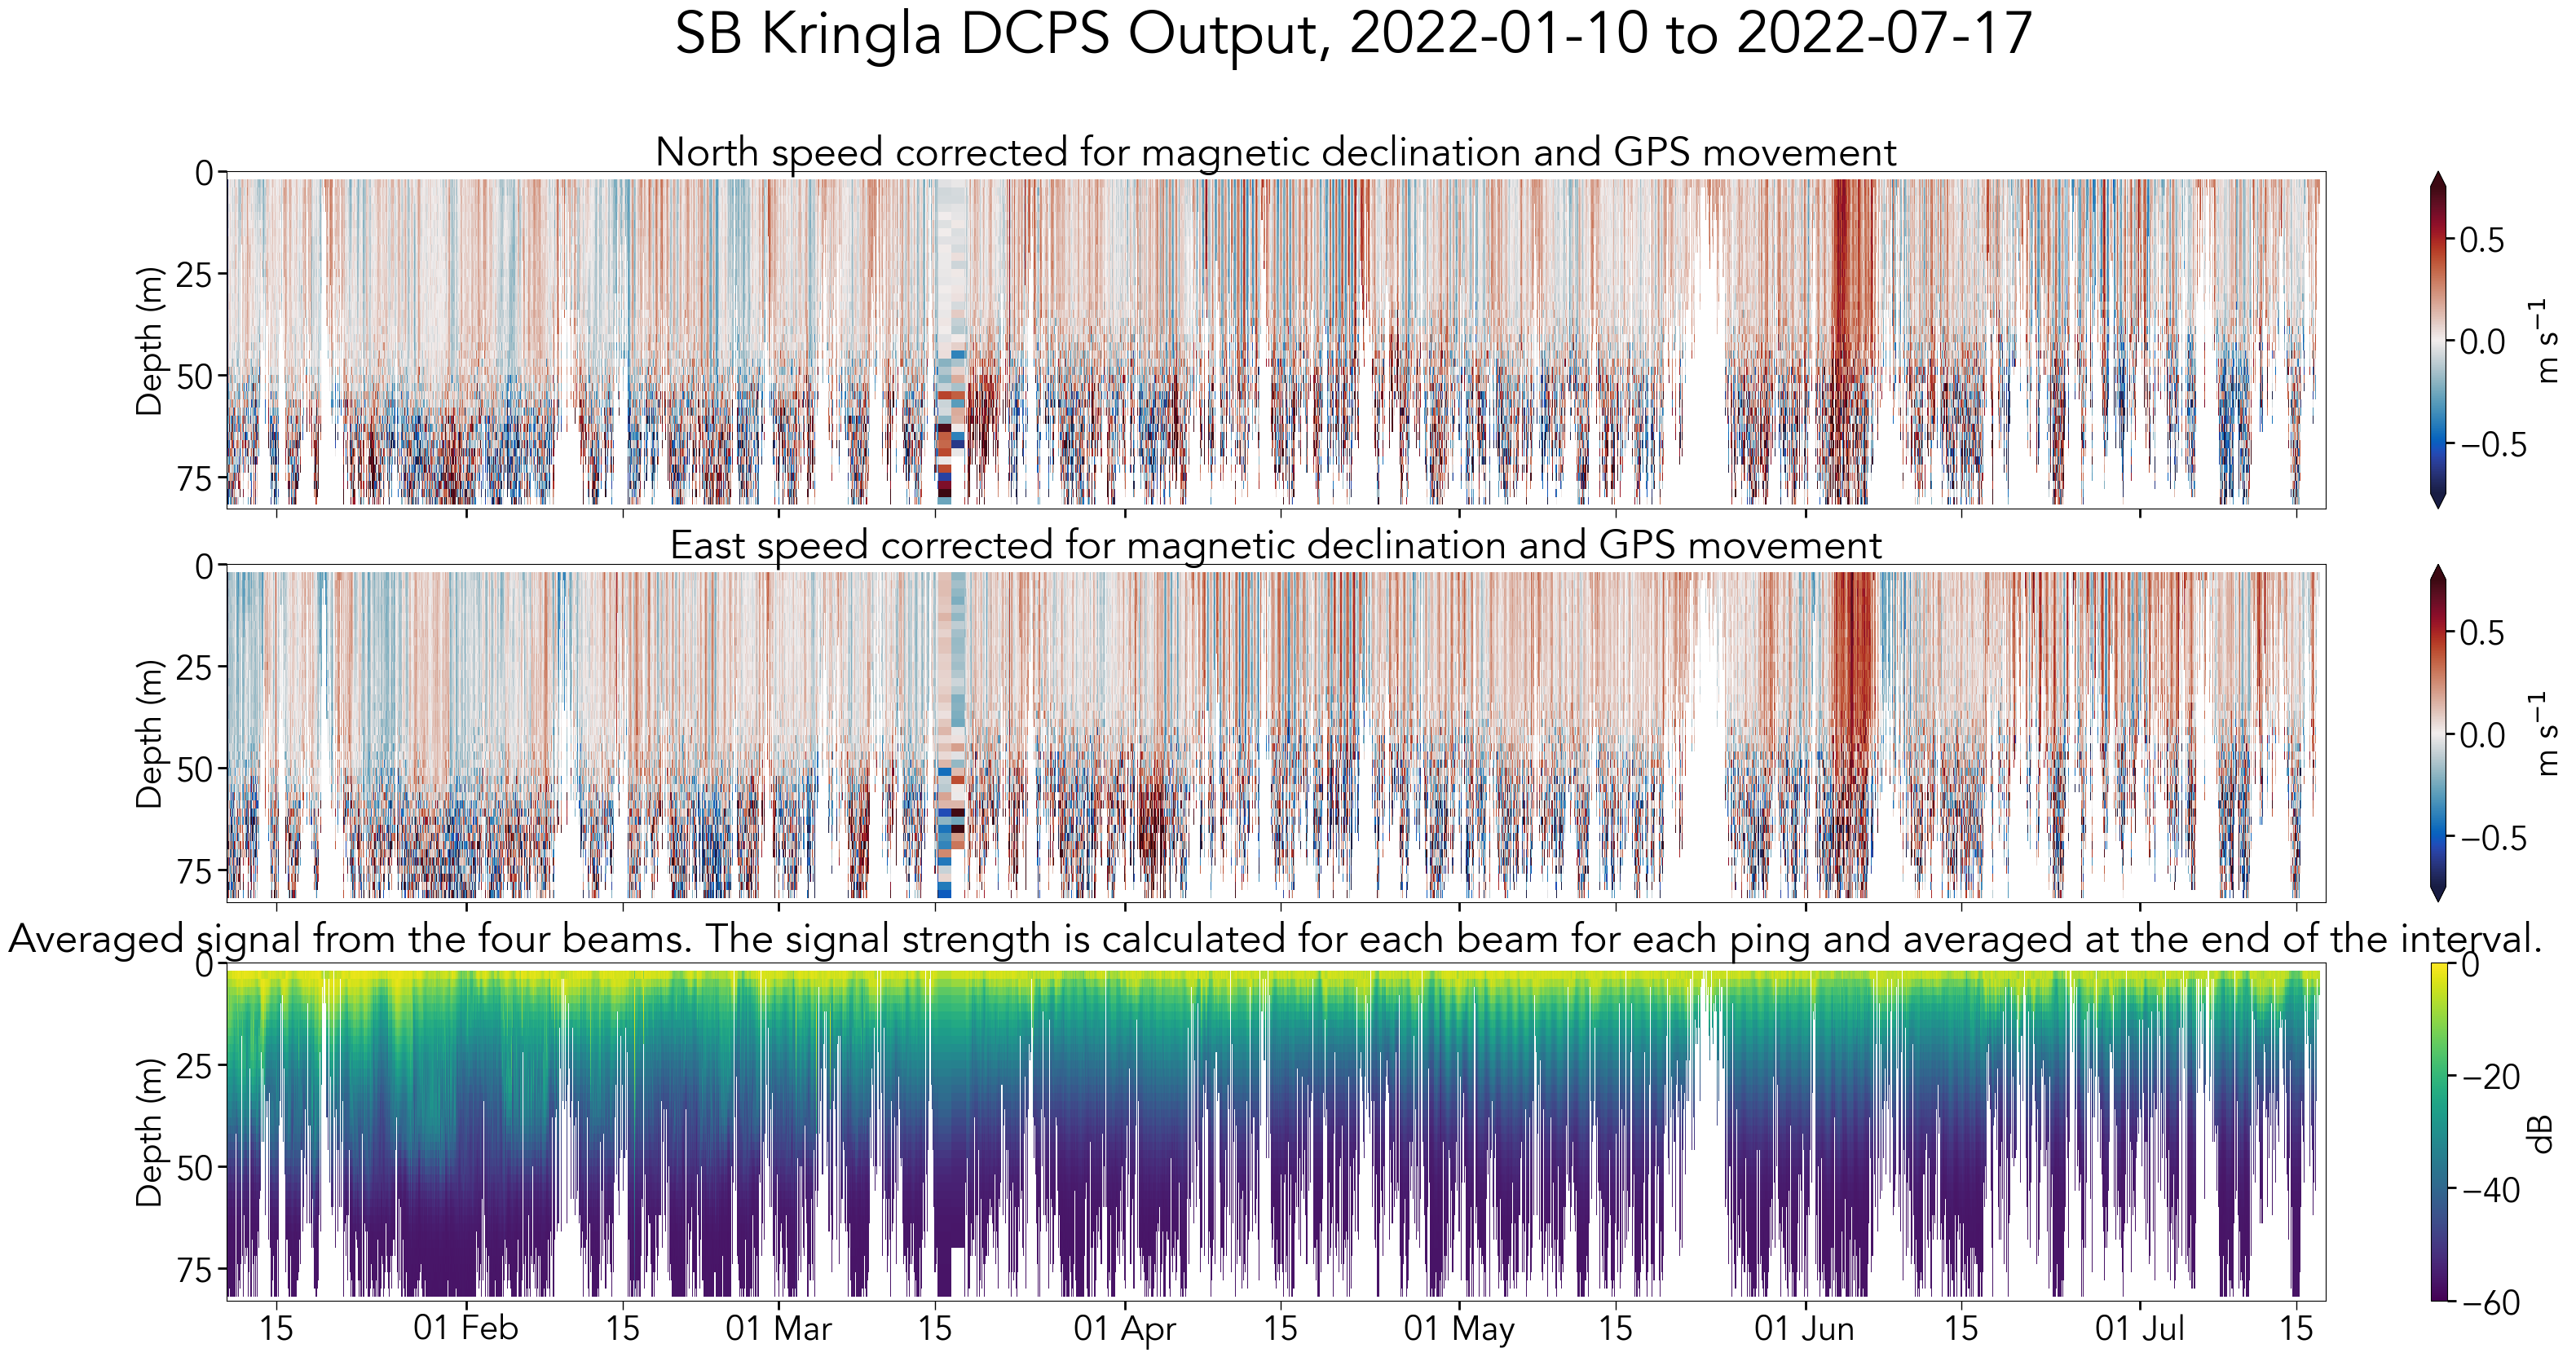

In [175]:
title = f"SB Kringla DCPS Output, {ds['time'][0].values.astype('datetime64[D]')} to {ds['time'][-1].values.astype('datetime64[D]')}"
dcps_plotting.NE_panels(ds = ds,
                        var = ['c_v_corr','c_u_corr','strength'],
                        vmin = [-0.75,-0.75,-60],
                        vmax = [0.75,0.75,0],
                        cmap = [cmo.balance,cmo.balance,'viridis'],
                        ylim = (83,0),
                        path = '../figs/panels.png',
                        title = title,
                        full = True
                       )


Velocities look good, there's a spike in the last quarter, which I believe is the Southern Boundary. There's also some data missing, that is being interpolated over by the plotting function around the 15-17 March, which is when Kringla was recovered by Polarstern.

Strength decays vertically, which is expected. The first flag from the manufacturer is at -40dB (2nd at -44dB, 3rd at -48dB), let's investigate where that is. Let's also bootstrap the strength and see how it varies.

### Evaluate strength signal

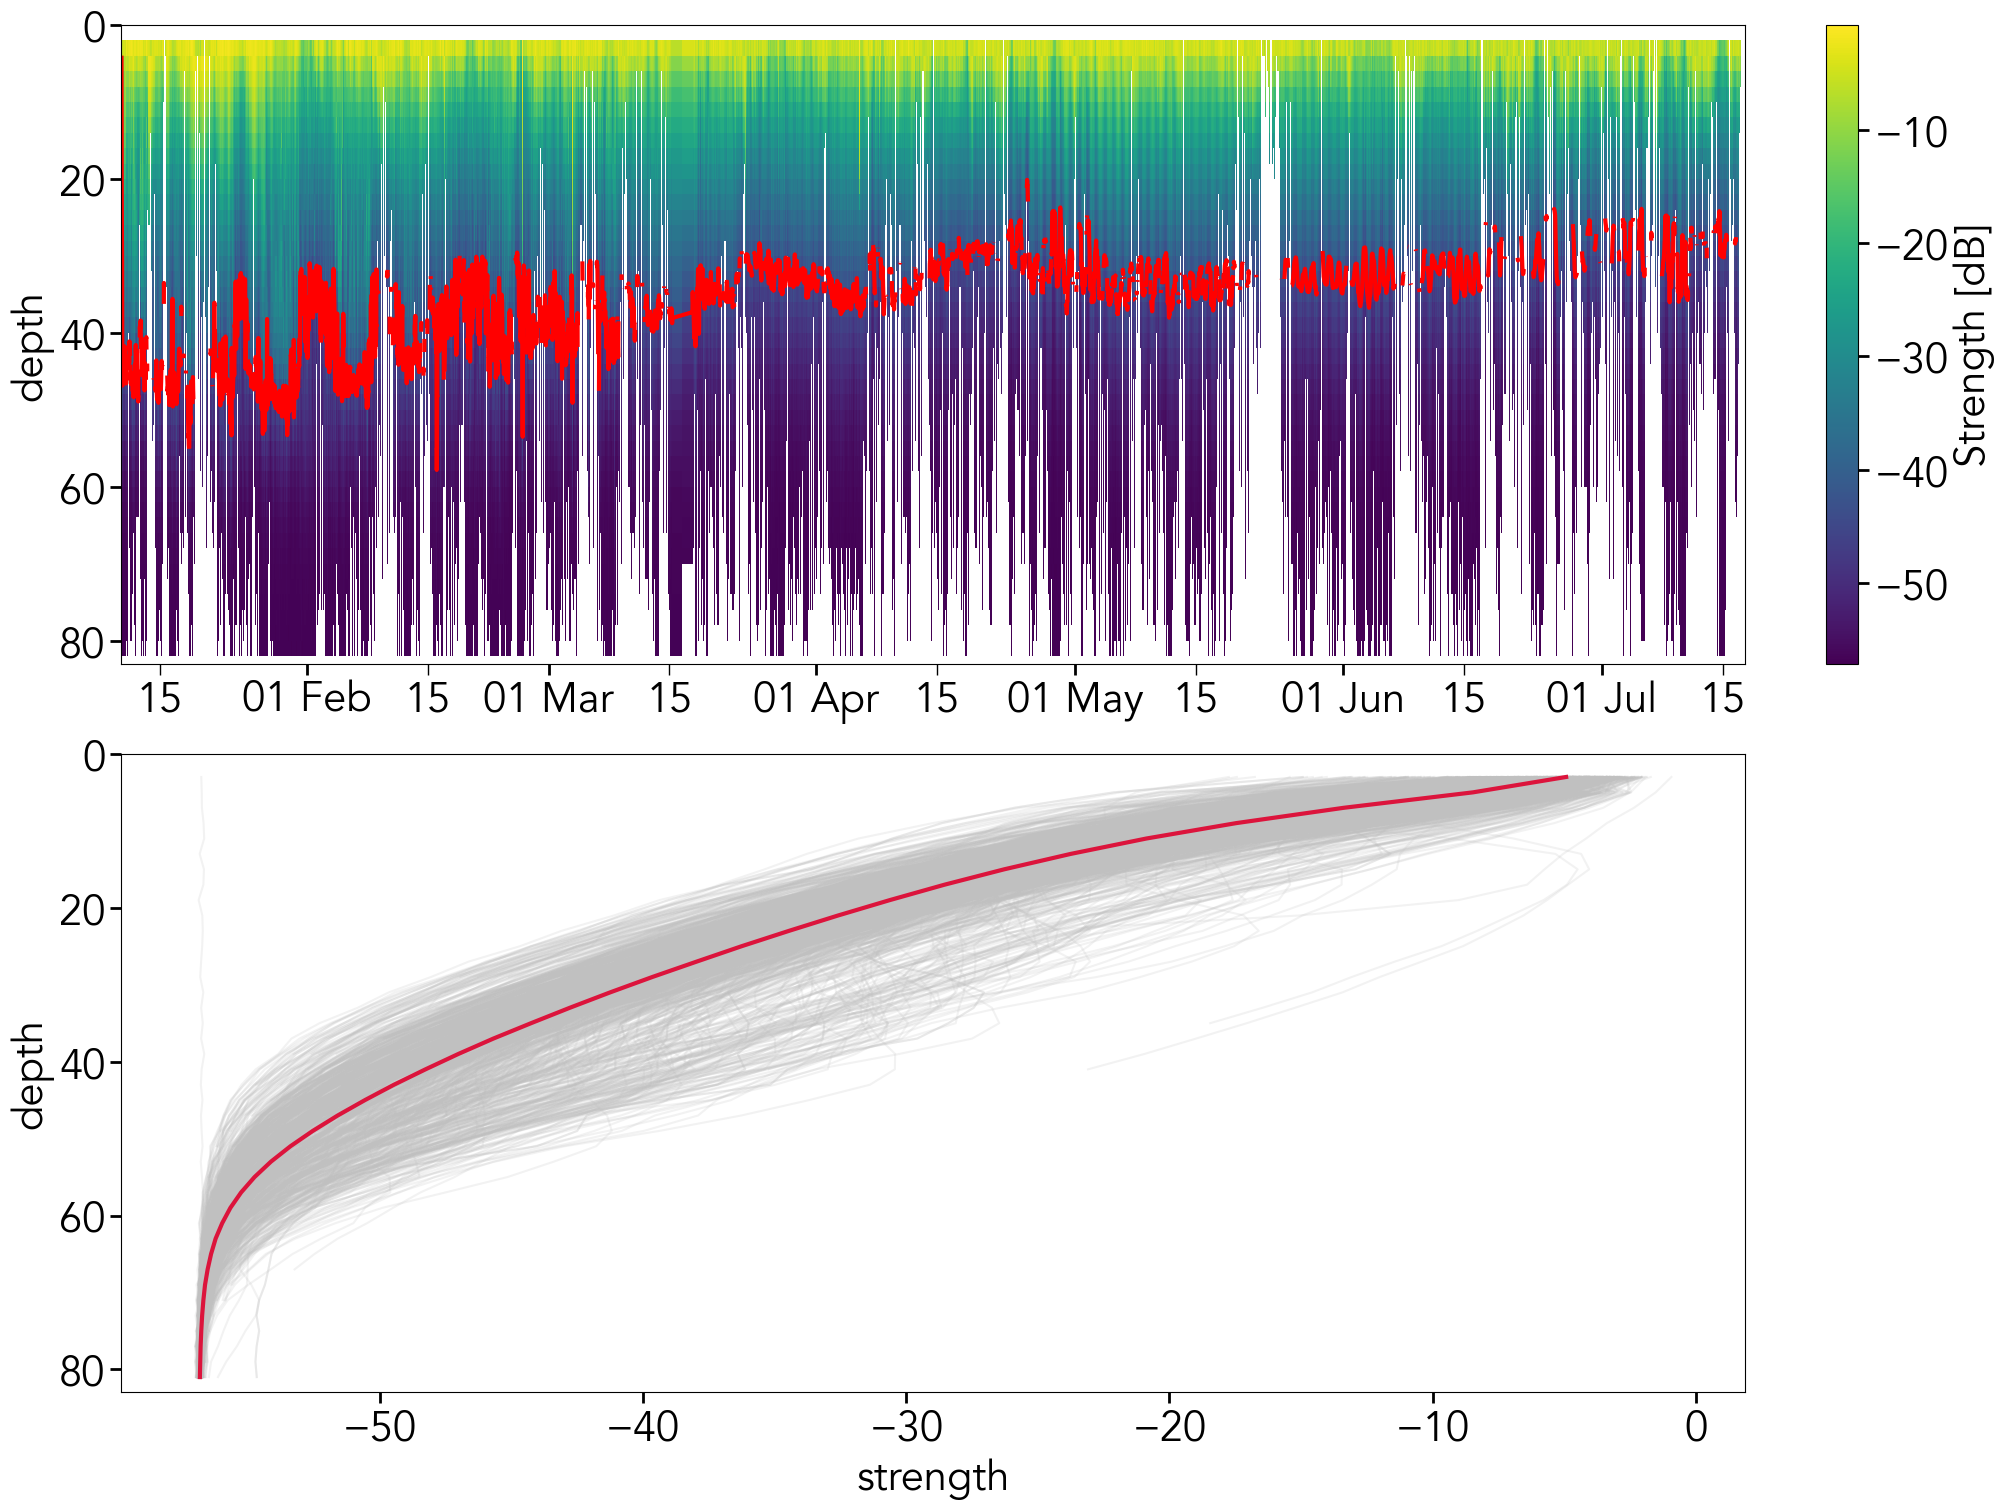

In [231]:
fig,ax = plt.subplots(2,1,figsize=(20,15),constrained_layout=True,facecolor='w')

I = np.sort(np.random.randint(len(ds.time),size=1000))

ds['strength'].plot(ax=ax[0],x='time',y='depth',ylim=(83,0))
ds['strength'].rolling(time=4,center=True).mean('time').plot.contour(y='depth',
                                                                     ylim=(83,0),
                                                                     x='time',
                                                                     levels=[-44],
                                                                     colors='r',linestyles='-',linewidths=3,ax=ax[0])

ax[0].xaxis.set_minor_locator(mdates.DayLocator([15]))
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
ax[0].set_xlabel('')
rot_ticks(ax[0],0,'center')

for i in range(1000):
    ds.isel(time=I[i])['strength'].plot(y='depth',ylim=(83,0),c='silver',ax=ax[1],alpha=0.2)

ds['strength'].median('time').plot(y='depth',ylim=(83,0),c='crimson',ax=ax[1],lw=3)
plt.show()

This plot shows the strength for the entire dataset, with the -40dB level (1hr rolling mean) plotted in red. A lot of the data is not going to be useful, but that's life, we can't use it if the strength values are too low as this would introduce noise into the dataset. Let's pick some individual datapoints and see how horizontal speed, standard deviation, and strength vary with depth.

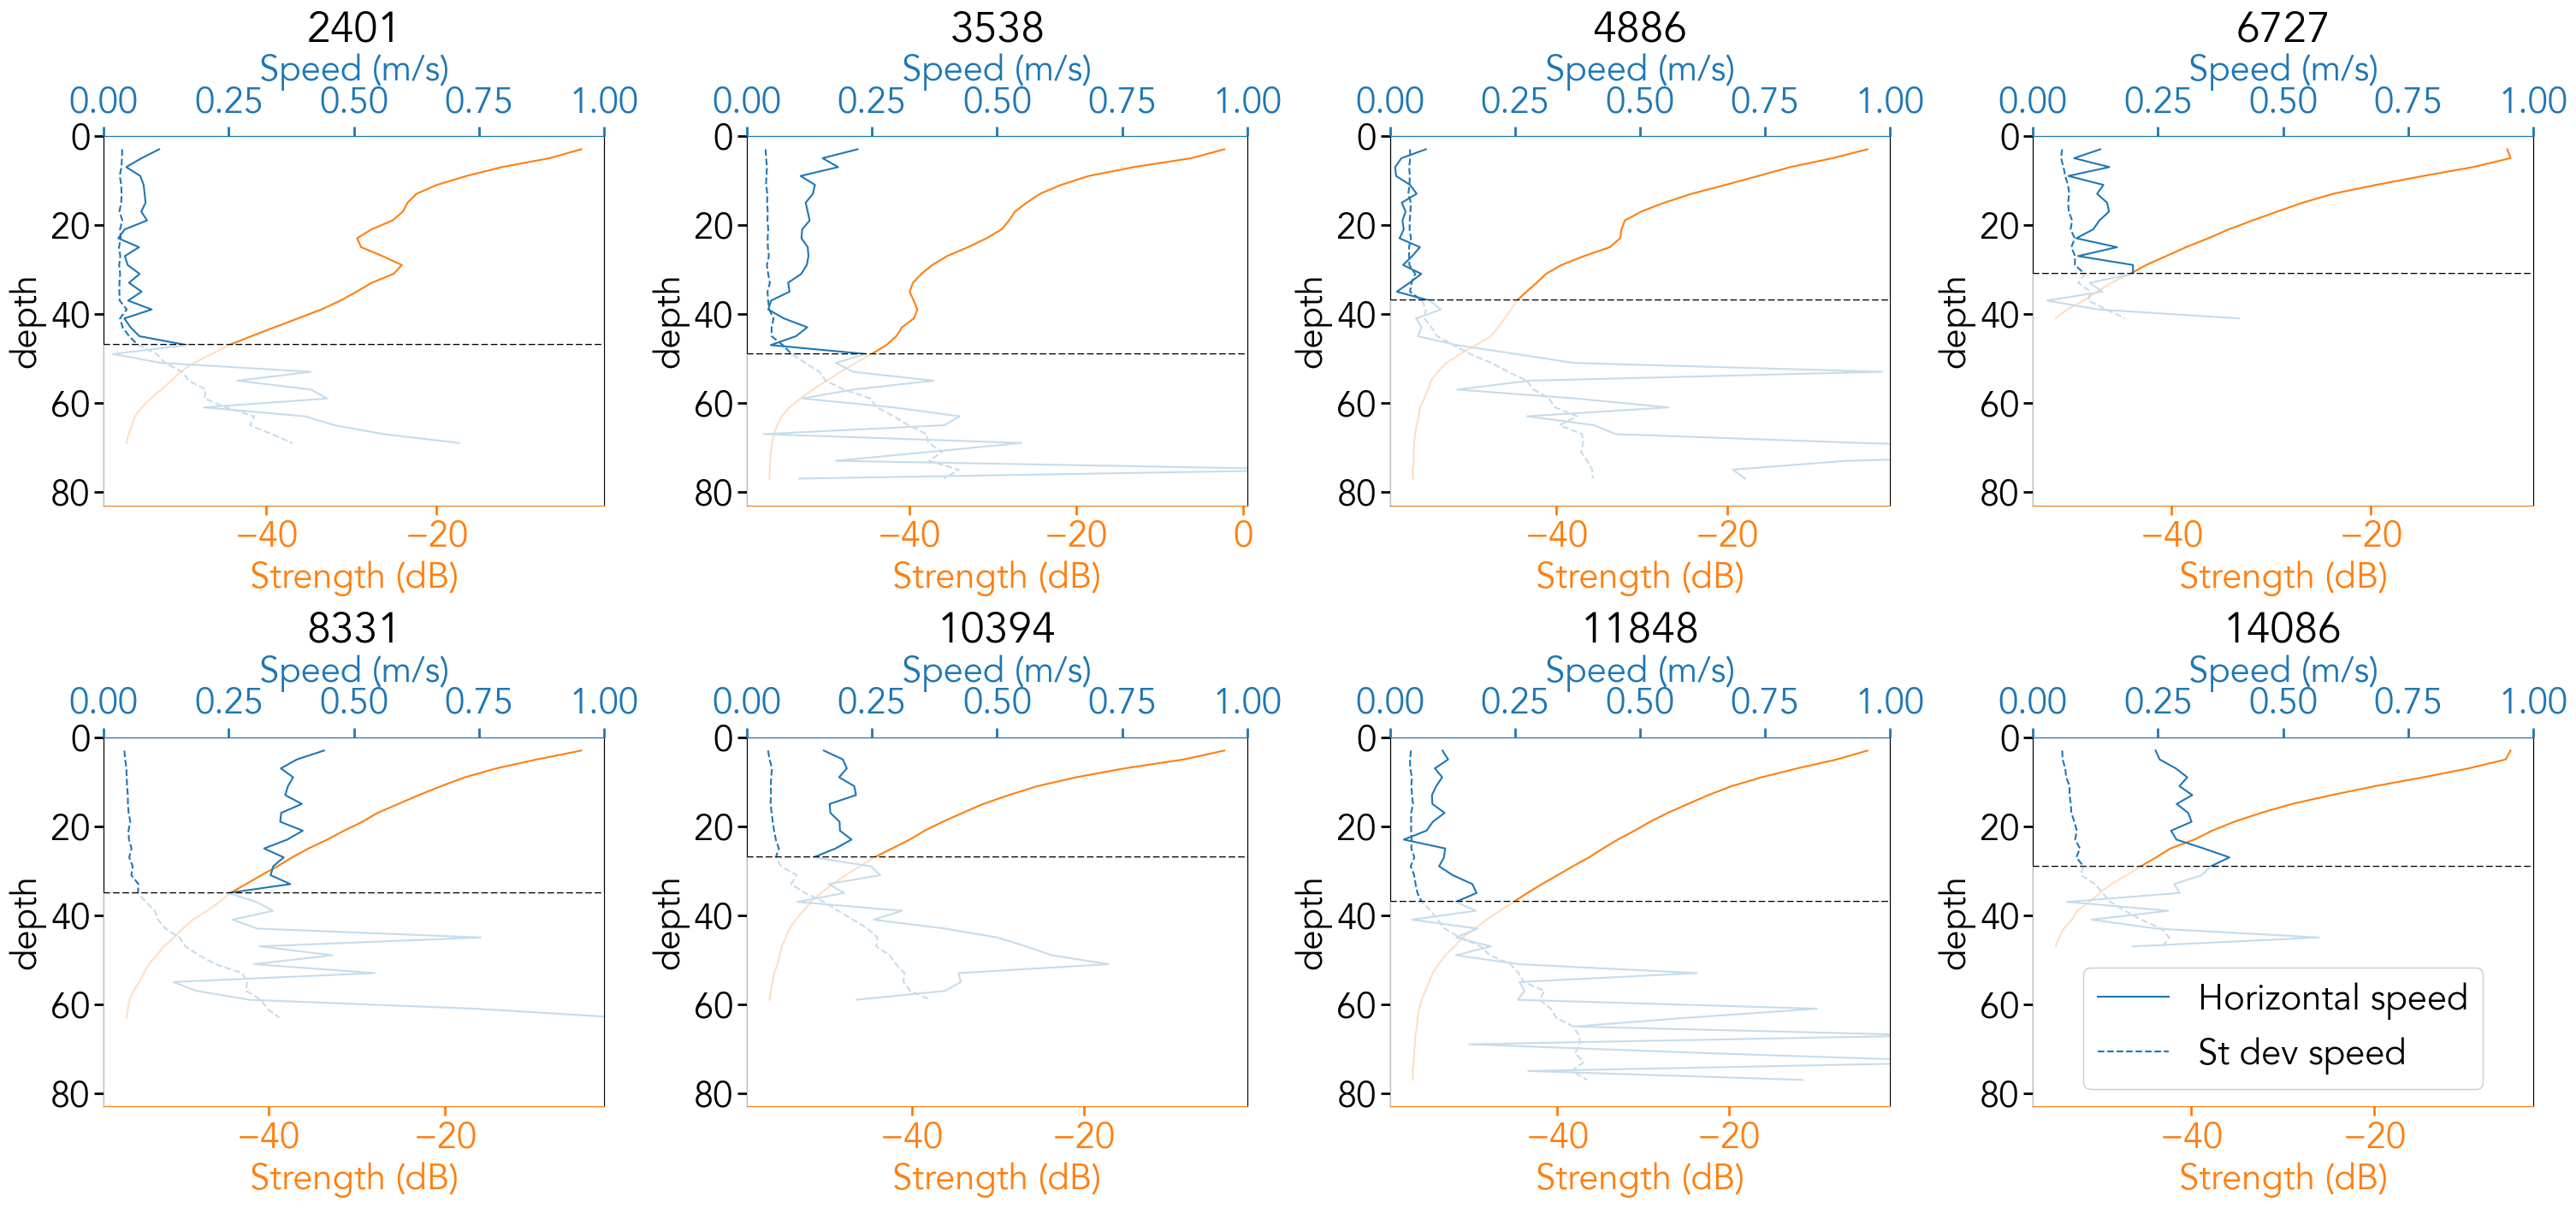

In [232]:
dcps_plotting.vertical_strength_plots(ds,'../figs/vertical_strength_plots.png')

The black dashed horizontal line represents the depth of -44dB, and it seems very much like that value is reasonable, as both st dev and horizontal speed have increased variability.

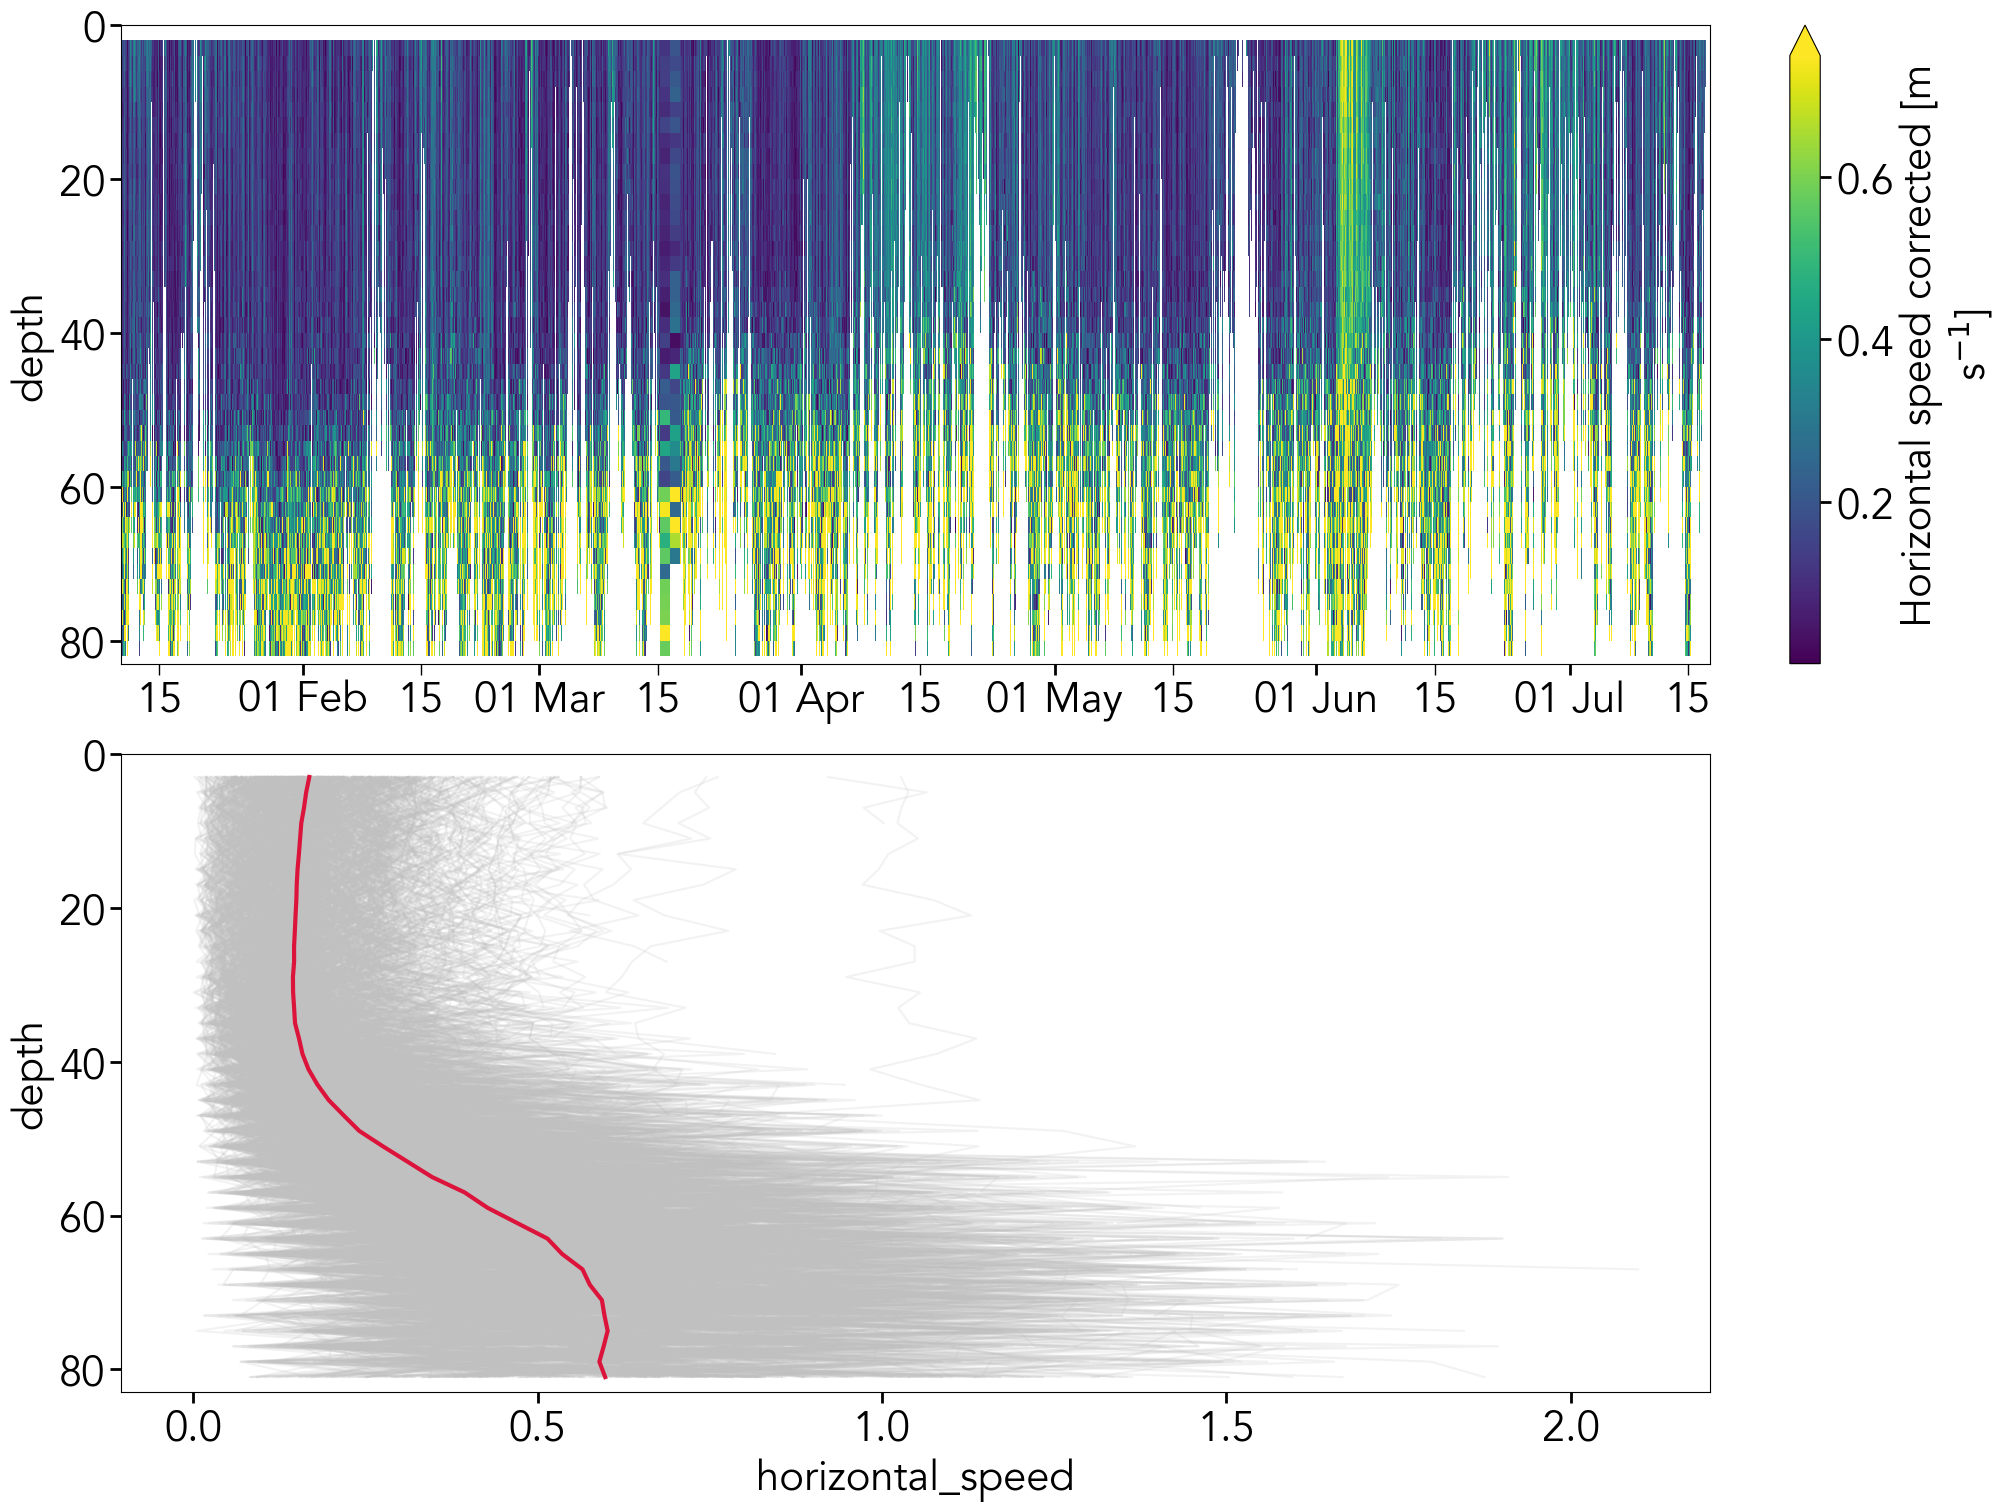

In [50]:
fig,ax = plt.subplots(2,1,figsize=(20,15),constrained_layout=True,facecolor='w')

I = np.sort(np.random.randint(len(ds.time),size=1000))

(ds['horizontal_speed']).plot(ax=ax[0],y='depth',ylim=(83,0),vmax=0.75)
# (ds['horizontal_speed']).rolling(time=4,center=True).mean('time').plot.contour(y='depth',
#                                                                      ylim=(83,0),
#                                                                      x='time',
#                                                                      levels=[0.1],
#                                                                      colors='r',linestyles='-',linewidths=3,ax=ax[0])

ax[0].xaxis.set_minor_locator(mdates.DayLocator([15]))
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
ax[0].set_xlabel('')
rot_ticks(ax[0],0,'center')

for i in range(1000):
    (ds.isel(time=I[i])['horizontal_speed']).plot(y='depth',ylim=(83,0),c='silver',ax=ax[1],alpha=0.2)

(ds['horizontal_speed']).median('time').plot(y='depth',ylim=(83,0),c='crimson',ax=ax[1],lw=3)
plt.show()

This shows the increased spread in horizontal speed as we get deeper, a lot of fake variability!

Let's set all values that correspond to a strenght < 40 dB to NaN.

In [233]:
cell_vars = ['cell_index',
             'cell_state1',
             'cell_state2',
             'horizontal_speed',
             'direction',
             'vel_north_raw',
             'vel_east_raw',
             'vel_up_raw',
             'sp_sd_horizontal',
             'strength',
             'b1_speed',
             'b2_speed',
             'b3_speed',
             'b4_speed',
             'b1_strength',
             'b2_strength',
             'b3_strength',
             'b4_strength',
             'b1_sd',
             'b2_sd',
             'b3_sd',
             'b4_sd',
             'correlation',
             'c_u_mag',
             'c_v_mag',
             'c_u_corr',
             'c_v_corr']

In [234]:
ds[cell_vars] = ds[cell_vars].where(ds['strength'] > -44)

Let's plot the same plot again, and see the difference.

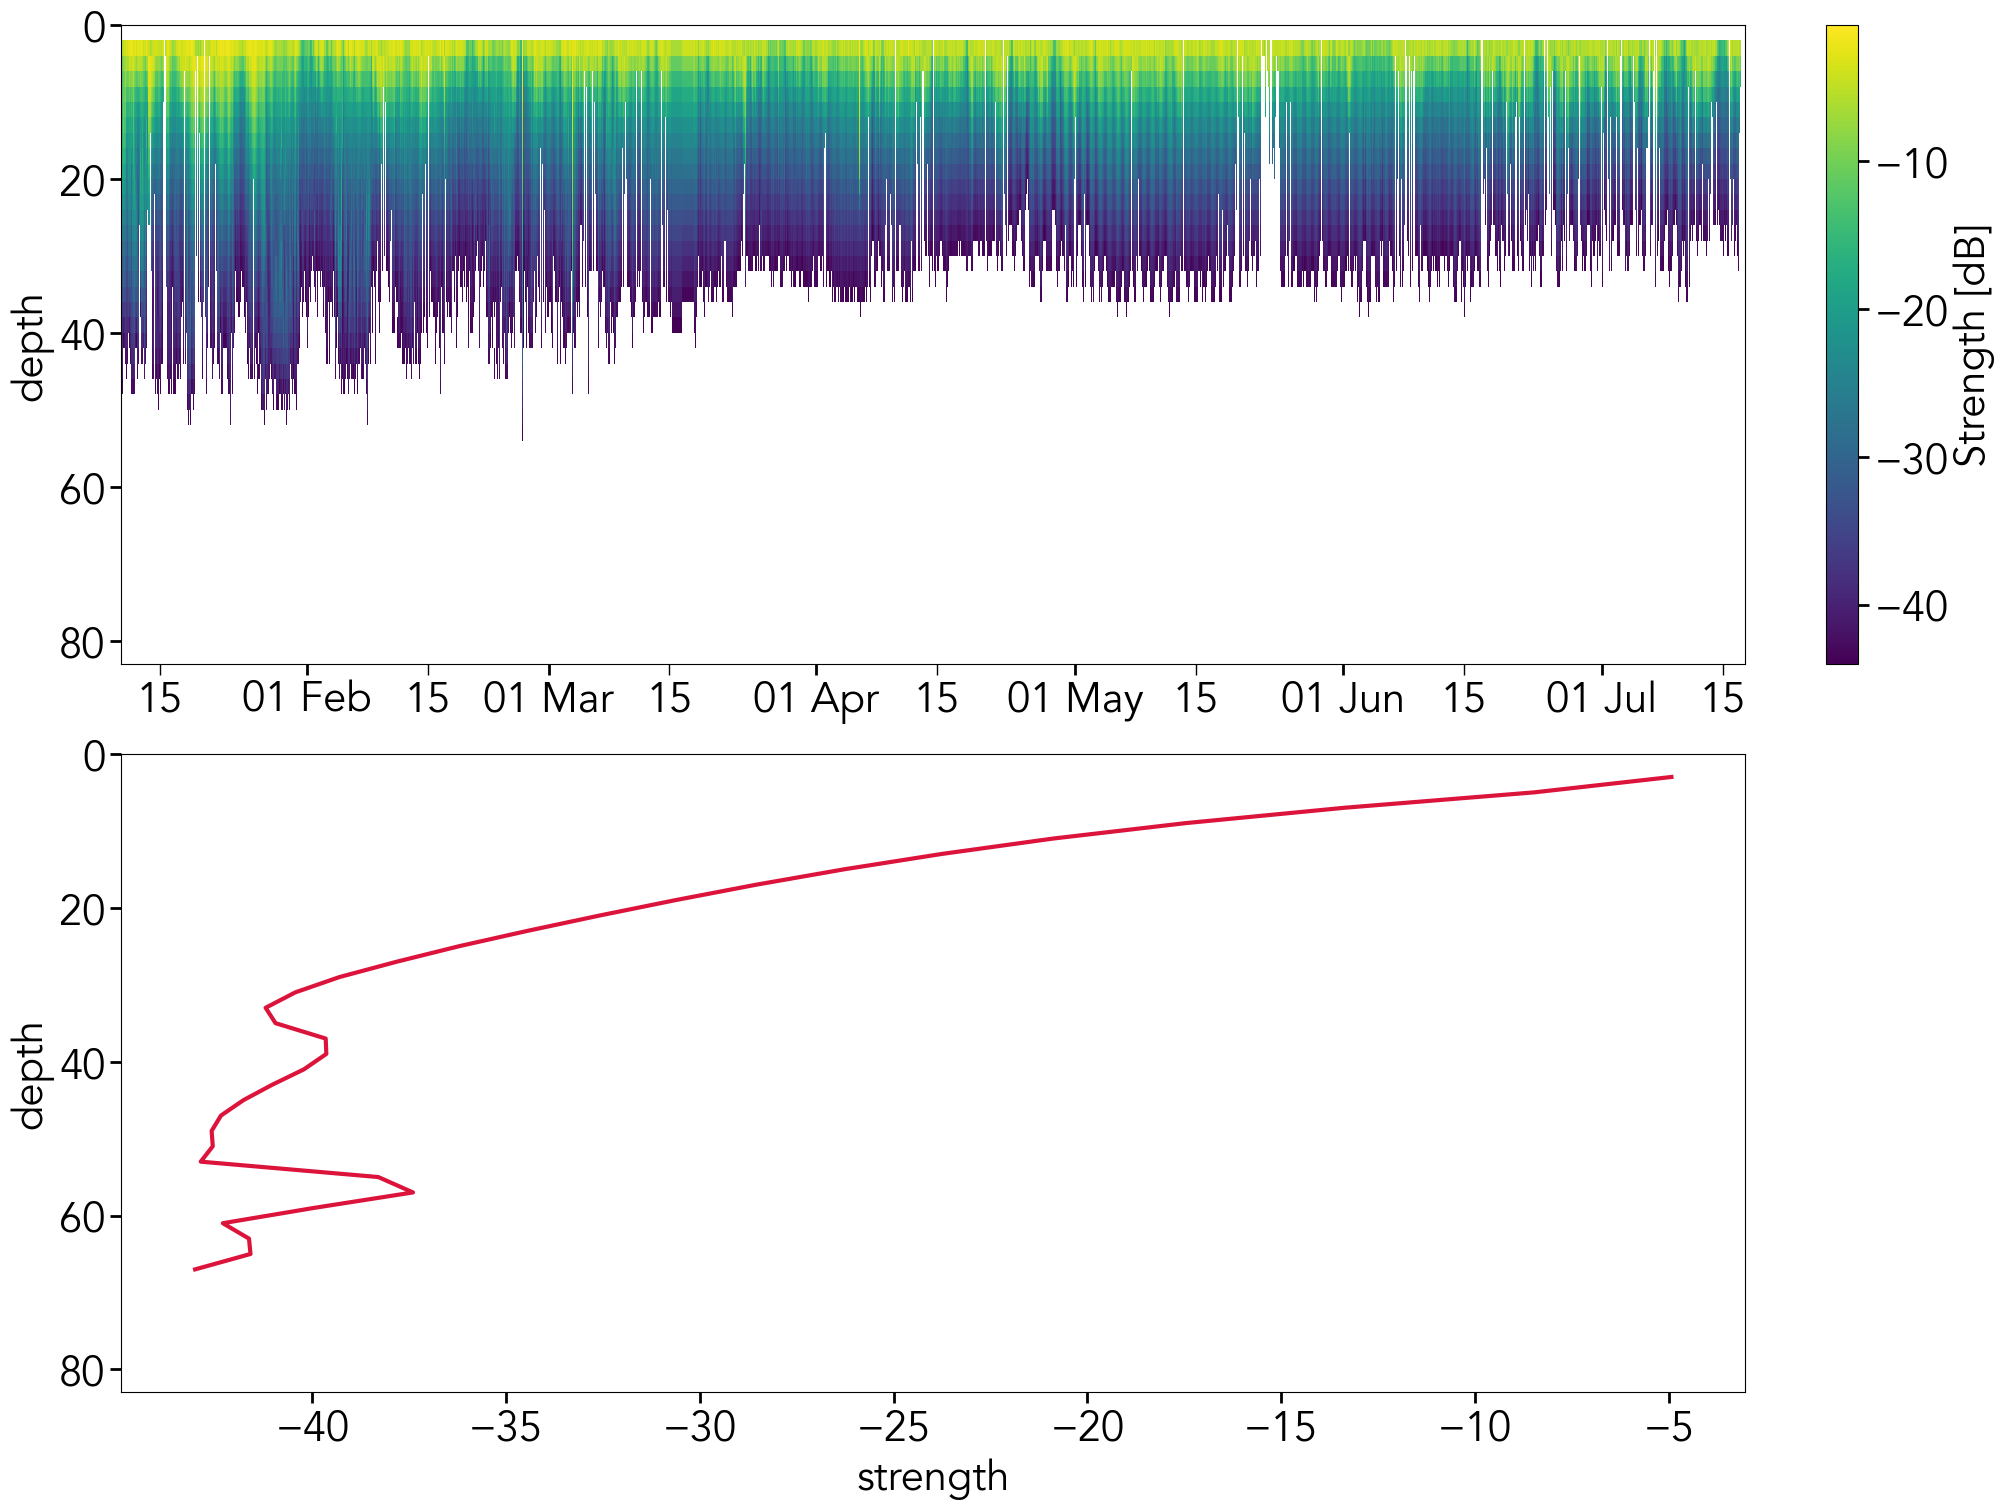

In [235]:
fig,ax = plt.subplots(2,1,figsize=(20,15),constrained_layout=True,facecolor='w')

I = np.sort(np.random.randint(len(ds.time),size=1000))

ds['strength'].plot(ax=ax[0],y='depth',ylim=(83,0))
# ds['strength'].rolling(time=4,center=True).mean('time').plot.contour(y='depth',
#                                                                      ylim=(83,0),
#                                                                      x='time',
#                                                                      levels=[-40],
#                                                                      colors='r',linestyles='-',linewidths=3,ax=ax[0])

ax[0].xaxis.set_minor_locator(mdates.DayLocator([15]))
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
ax[0].set_xlabel('')
rot_ticks(ax[0],0,'center')

#for i in tqdm(range(len(ds['time'])),'Plotting each line'):
#    ds.isel(time=i)['strength'].plot(y='depth',ylim=(83,0),c='silver',ax=ax[1],alpha=0.2)

ds['strength'].median('time').plot(y='depth',ylim=(83,0),c='crimson',ax=ax[1],lw=3)
plt.show()

And let us also compare with the histograms, to see if they have improved.

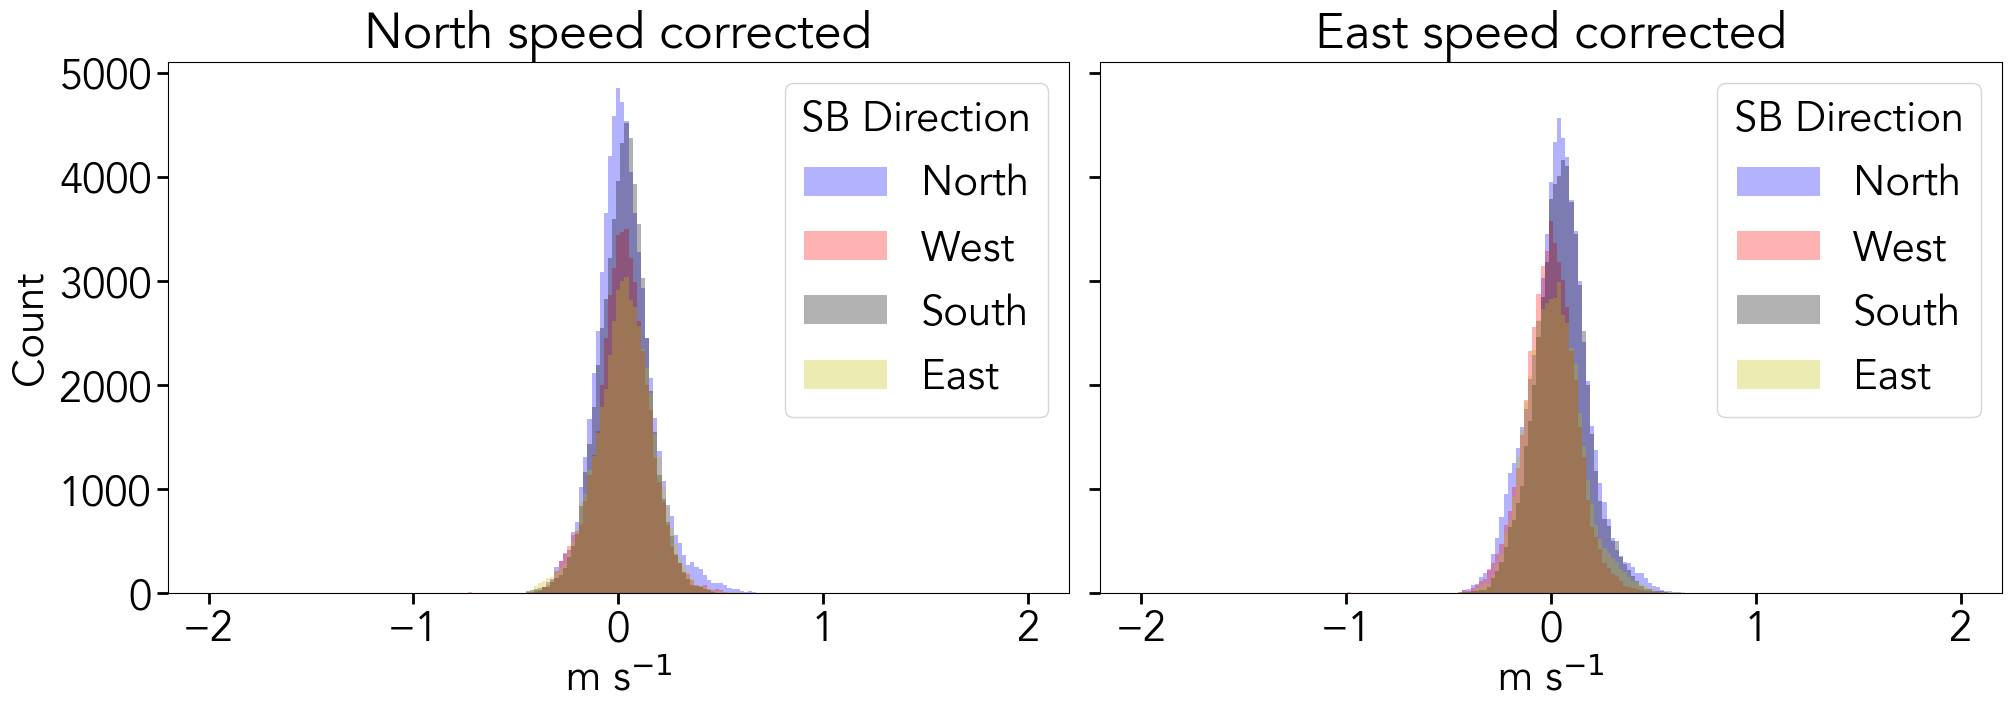

In [236]:
dcps_plotting.heading_dist(ds,2,'c_v_corr','c_u_corr','../figs/ne_qc_hist_44dB.png')

Much tighter, nice!

Speaking of histograms, we will need to take a look at the standard deviation for the heading during each sample, and some other variables, let's do that now.

### Evaluate some other sensor outputs

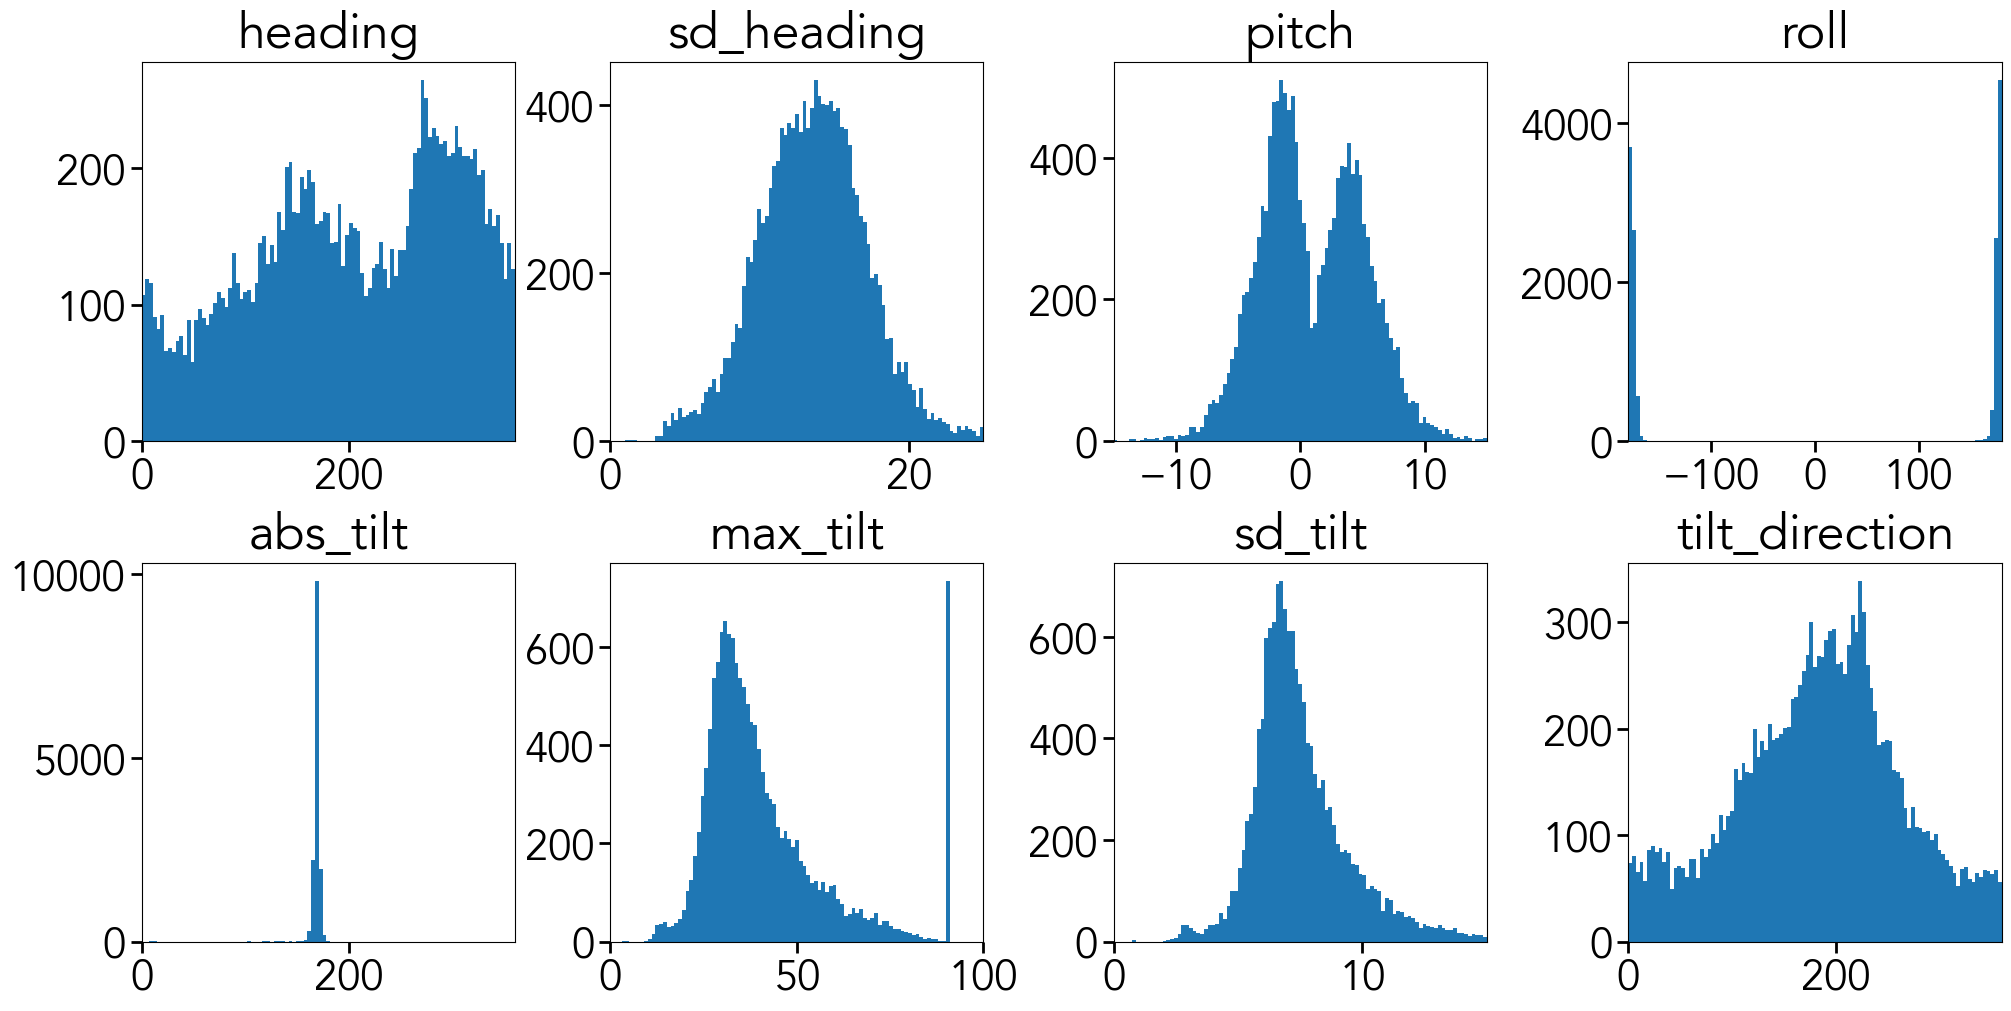

In [72]:
fig,ax=plt.subplots(2,4,figsize=(20,10),constrained_layout=True)
var = ['heading','sd_heading','pitch','roll','abs_tilt','max_tilt','sd_tilt','tilt_direction']
c = 0
lims = [[0,360],[0,25],[-15,15],[-180,180],[0,360],[0,100],[0,15],[0,360]]
for i in range(2):
    for j in range(4):   
        _=ax[i][j].hist(ds[var[c]],bins=np.linspace(lims[c][0],lims[c][1],100))
        ax[i][j].set_title(var[c])
        ax[i][j].set_xlim(lims[c])
        c+=1


The sensor have flags for two of these, *sd_heading* and *sd_tilt*. The levels are the same for both, first flag at 10°, second at 20°, and third at 30°. From the plots above, we can see that almost the entire dataset have a *st_heading* greater than 10°. We should consider setting our limit to 20°, aligning with the second flag. For tilt we could use the first flag. I'm concerned about the ~700 or so values that have a maximum tilt of 90°, meaning that the SB is on its side.

I'm not super sure that we should do this correction (trying some stuff)

In [237]:
ds = ds.where(ds['sd_heading'] < 20).where(ds['sd_tilt'] < 10)

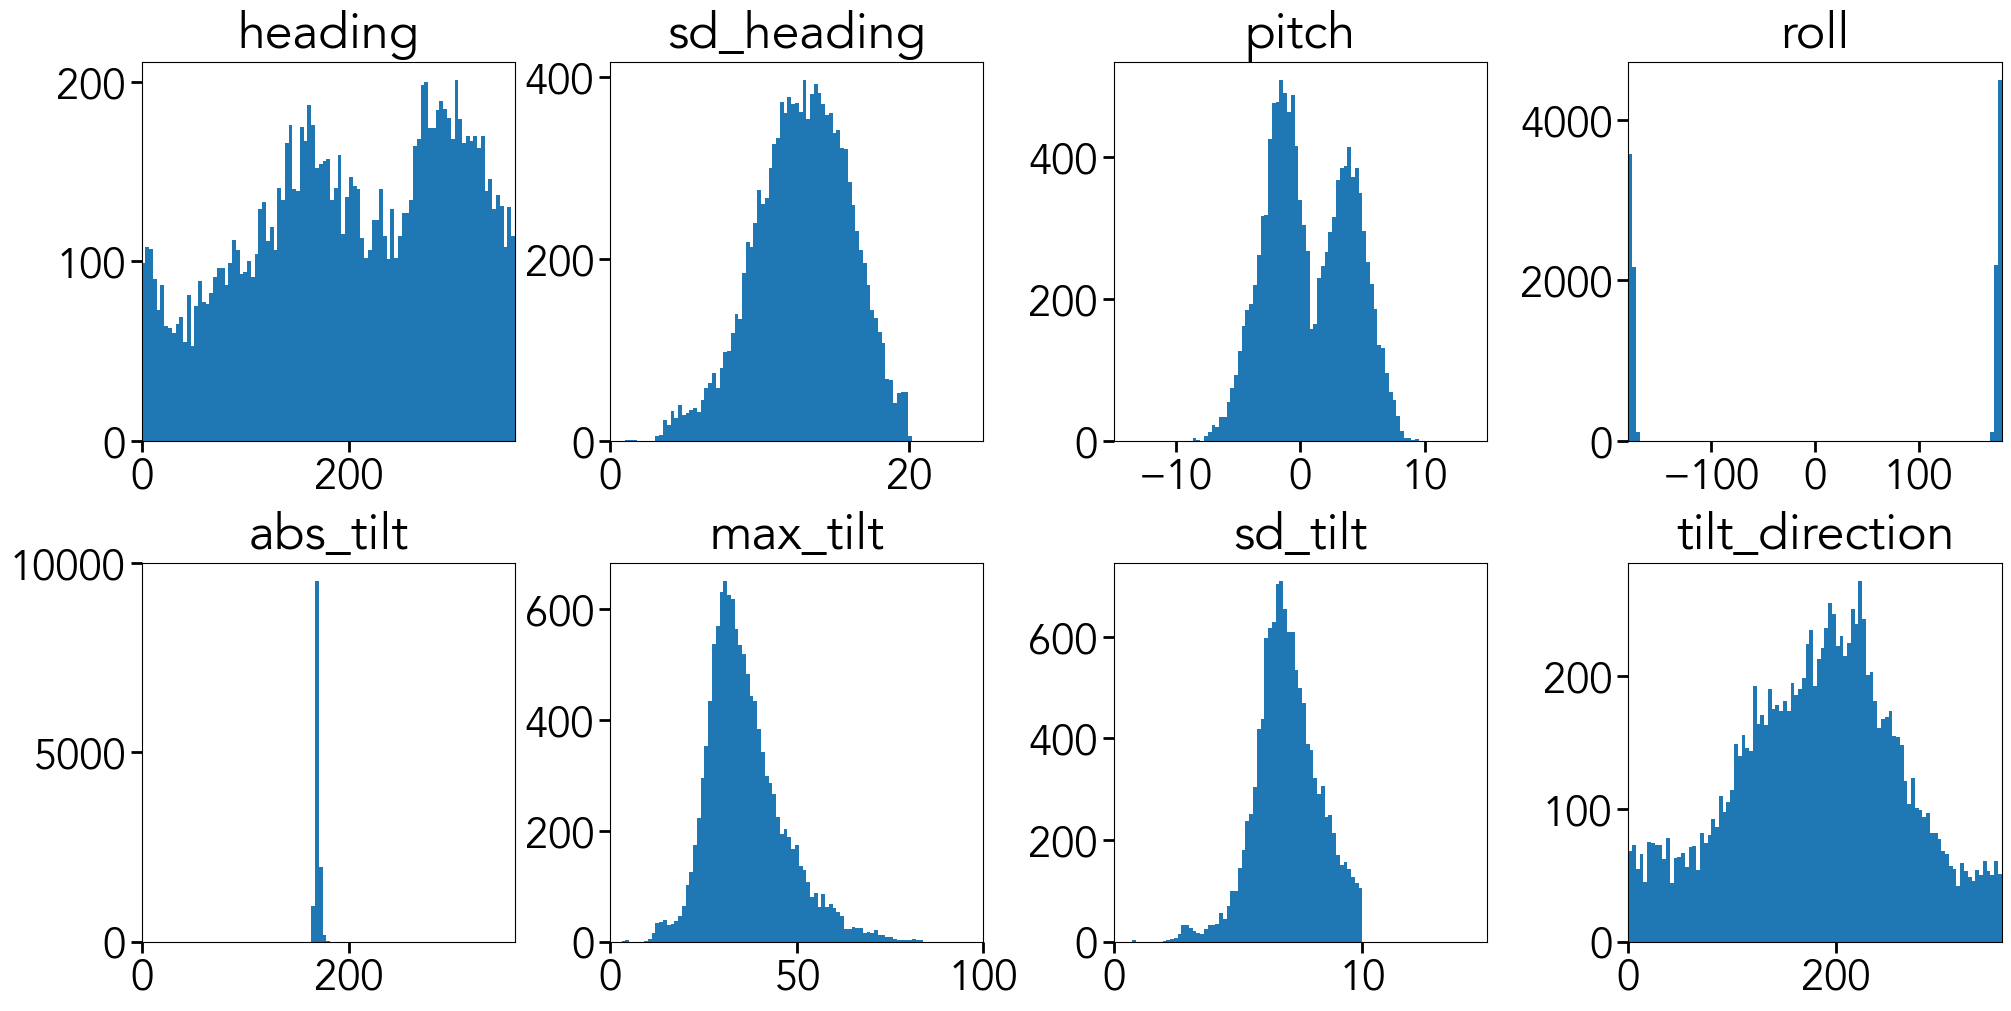

In [260]:
fig,ax=plt.subplots(2,4,figsize=(20,10),constrained_layout=True)
var = ['heading','sd_heading','pitch','roll','abs_tilt','max_tilt','sd_tilt','tilt_direction']
c = 0
lims = [[0,360],[0,25],[-15,15],[-180,180],[0,360],[0,100],[0,15],[0,360]]
for i in range(2):
    for j in range(4):   
        _=ax[i][j].hist(ds[var[c]],bins=np.linspace(lims[c][0],lims[c][1],100))
        ax[i][j].set_title(var[c])
        ax[i][j].set_xlim(lims[c])
        c+=1


Looks better, but let's remove the 90° *max_tilt* as well.

In [238]:
ds = ds.where(ds['max_tilt'] < 85)

In [239]:
ds.to_netcdf('/Volumes/MASSIVEUNIT/Work/SOCHIC_2022/Sailbuoy/data/dcps_44dB.nc',mode='w')

### Correcting for sound speed

We want to correct the velocity for differences in the speed of sound, as is done by the Saildrones.

$V_{corrected} = V_{uncorrected} * \left (  \frac{V_{sound}}{1500 m/s} \right )$

To do this we need to co-locate the DCPS data with the dataloggers data

Checkpoint

In [43]:
ds = xr.open_dataset('/Volumes/MASSIVEUNIT/Work/SOCHIC_2022/Sailbuoy/data/dcps_44dB.nc')
data = xr.open_dataset('/Volumes/MASSIVEUNIT/Work/SOCHIC_2022/Sailbuoy/data/data.nc')

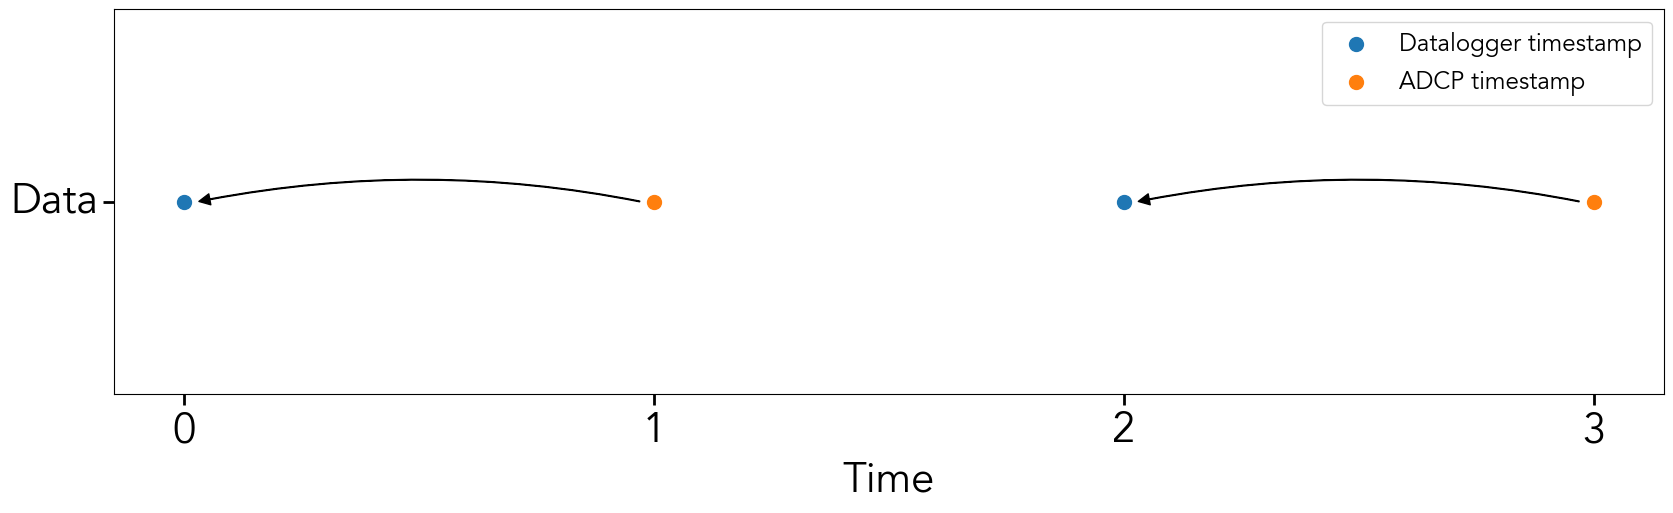

In [166]:
fig,ax = plt.subplots(figsize=(20,5))

ax.scatter([0,2],[1,1],s=100,label='Datalogger timestamp')
ax.scatter([1,3],[1,1],s=100,label='ADCP timestamp')

style = "Simple, tail_width=0.5, head_width=8, head_length=8"
kw = dict(arrowstyle=style, color="k")

arrow1 = mpl.patches.FancyArrowPatch((0.975, 1), (0.025, 1),connectionstyle="arc3,rad=0.1",**kw)
arrow2 = mpl.patches.FancyArrowPatch((2.975, 1), (2.025, 1),connectionstyle="arc3,rad=0.1",**kw)
ax.add_patch(arrow1)
ax.add_patch(arrow2)



ax.set_yticks([1])
ax.set_yticklabels(['Data'],va='center')
ax.set_ylim(0,2)
ax.set_xticks([0,1,2,3])
ax.set_xlabel('Time')

ax.legend(fontsize='xx-small')
plt.show()

Since the datalogger turns on first, and registers this timestamp as *the one*, we need to move the timestamp for the DCPS to be able to match the other measurements, to correct for speed of sound etc..

Salinity, temperature, winds, are all on the *datalogger time*, but if we were to look at the individual sensor output, like later with the RBR possibly, then we need to do this for that sensor as well.

In [44]:
# Select times in data that match the ADCP
data_ds = data.sel(time=ds['time'].values,method='nearest')
j = len(ds['time'])
# Select unique times
_, idx  = np.unique(data_ds['time'].values, return_index=True)
data_ds = data_ds.isel(time=idx)
ds = ds.isel(time=idx)
# Set the time, lon, and lat
ds['time'] = data_ds['time']
ds['latitude'] = data_ds['latitude']
ds['longitude'] = data_ds['longitude']

print(f"We lost {j - len(ds['time'])} data points.")

We lost 22 data points.


In [45]:
# Assign some new variables 
ds['vel_east']   = ds['c_u_corr']
ds['vel_north']  = ds['c_v_corr']
# Correct for the speed of sound
ds['vel_east'].values   = ds['c_u_corr'] * (gsw.sound_speed(data_ds['sss'],data_ds['sst'],gsw.p_from_z(-ds['depth'],ds['latitude'])).values / 1500).transpose()
ds['vel_north'].values  = ds['c_v_corr'] * (gsw.sound_speed(data_ds['sss'],data_ds['sst'],gsw.p_from_z(-ds['depth'],ds['latitude'])).values / 1500).transpose()



In [46]:
ds_merged = xr.merge([ds,data_ds.drop(['longitude','latitude'])])

In [266]:
var_to_save = ['vel_east','vel_north','air_temp','wind_dir','wind_speed','wind_gust','sss','sst']
ds_merged[var_to_save].to_netcdf('/Volumes/MASSIVEUNIT/Work/SOCHIC_2022/Sailbuoy/data/ds_data_merged.nc')

More or less done. Some more checks are done below, but so far they have led to nothing.

### Looking into the difference between heading and sample heading

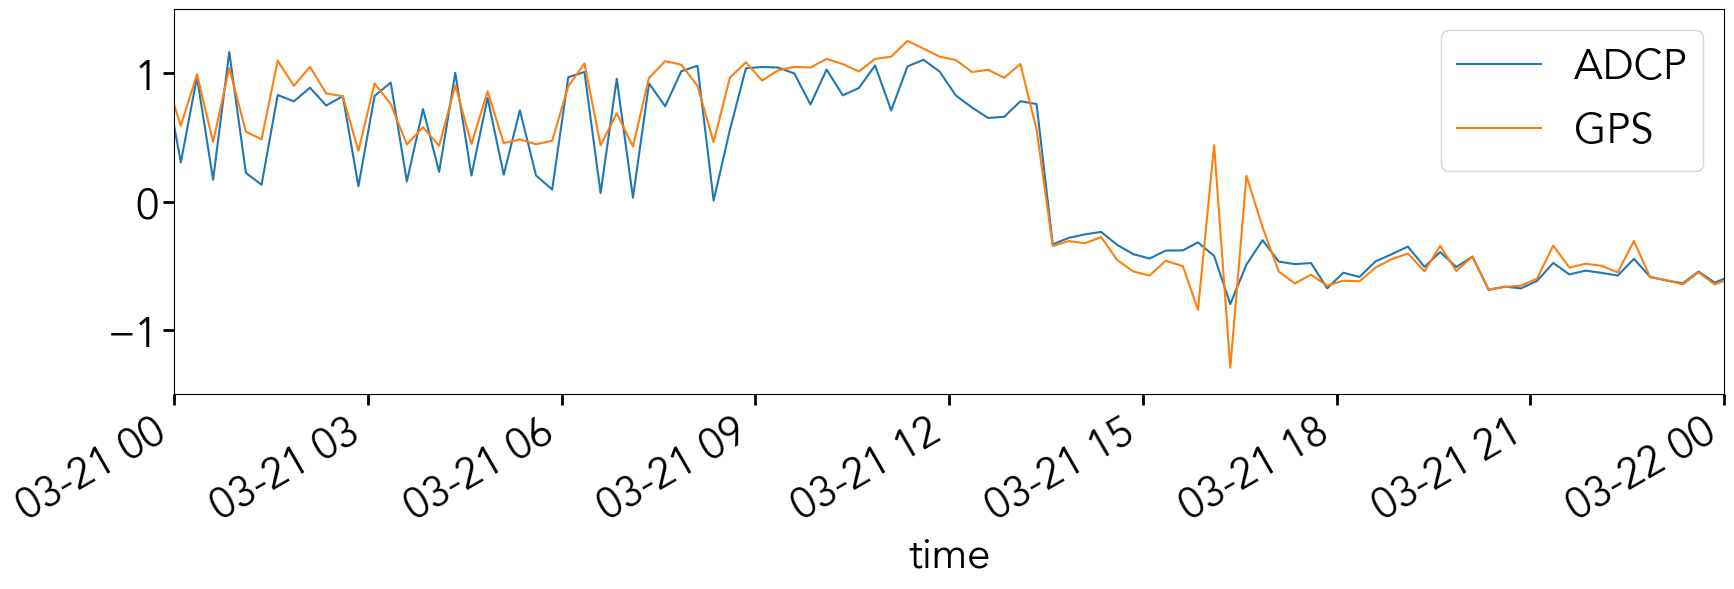

In [ ]:
plt.figure(figsize=(20,5))
a = (ds['sample_vel'] * np.cos(np.deg2rad(ds['heading'])))
b = (ds['sample_vel'] * np.cos(np.deg2rad(ds['sample_heading'])))
a.plot(label='ADCP')
b.plot(label='GPS')
plt.xlim(np.datetime64('2022-03-21'),np.datetime64('2022-03-22'))
plt.ylim(-1.5,1.5)
plt.legend()

In [ ]:
bb = ds_merged[['heading','sample_u','sample_v','wind_dir','wind_speed','sample_heading','sd_heading','airmar_gpsfix']]

Text(0.5, 0, "((((bb['heading'] + 45 ) % 360 -21 ) % 360 - bb['sample_heading']) + 180) % 360 - 180")

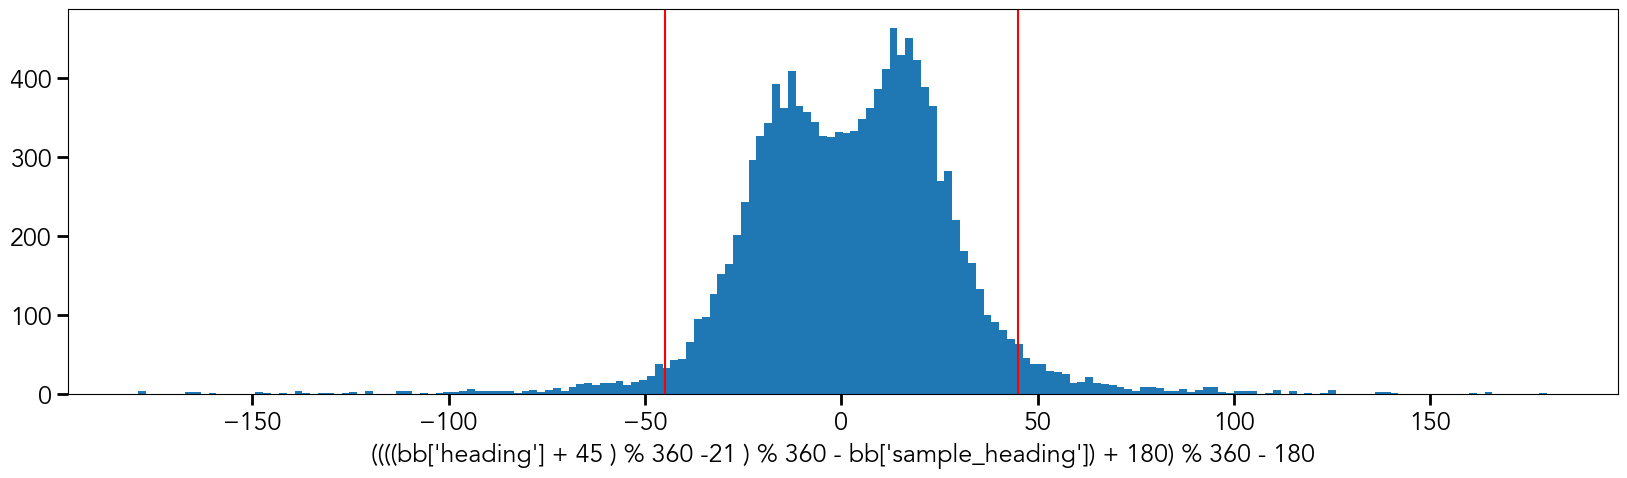

In [ ]:
plt.figure(figsize=(20,5))
a = (bb['heading']+45-21)%360
b = bb['sample_heading']
_=plt.hist(((a-b) + 180) % 360 - 180,bins=180)
plt.axvline(45,c='r')
plt.axvline(-45,c='r')
plt.xlabel("((((bb['heading'] + 45 ) % 360 -21 ) % 360 - bb['sample_heading']) + 180) % 360 - 180")
#plt.xlim(-100,100)

In [ ]:
ds_a = ds_merged.where(np.abs(((a-b)+180)%360-180) < 45)#.to_netcdf('/Volumes/MASSIVEUNIT/Work/SOCHIC_2022/Sailbuoy/data/merged_test.nc')

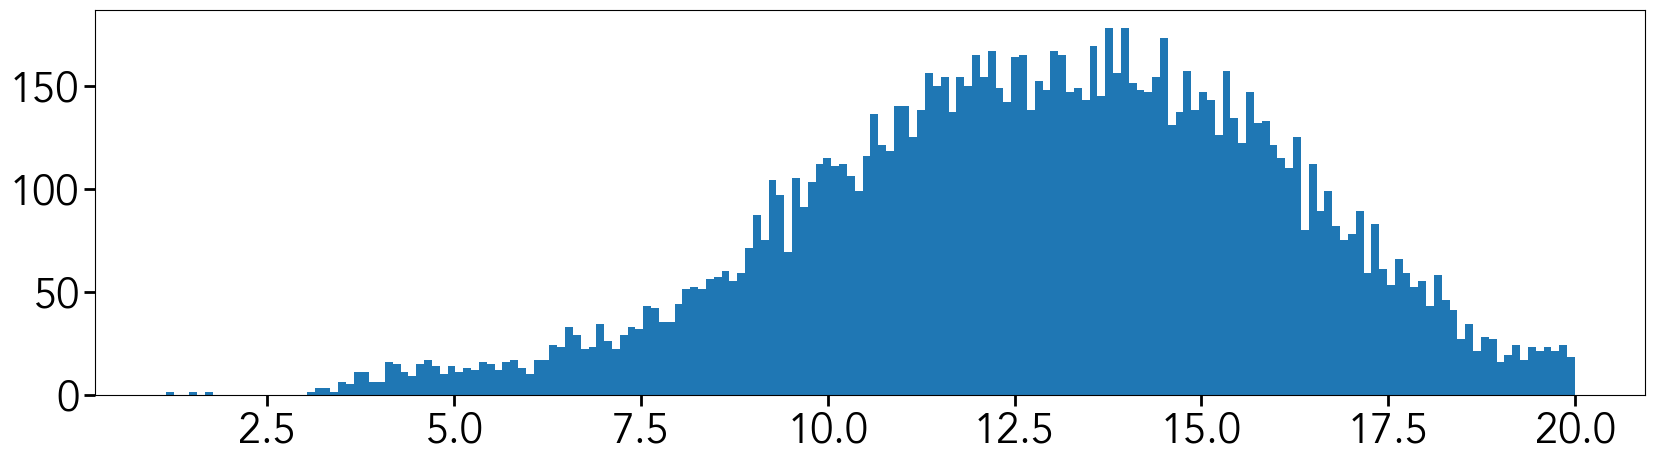

In [ ]:
plt.figure(figsize=(20,5))
_=plt.hist(bb['sd_heading'],bins=180)


In [48]:
msk = np.where(bb['airmar_gpsfix'] == 1)[0]
hdg = (((bb['heading']+45)%360-21)%360)[msk]
#hdg = bb['heading']#[msk]
#hdg = bb['sample_heading'][msk]
wdir = bb['wind_dir'][msk]
#wdiff = (((wdir+180)%360 - hdg) + 180) % 360 - 180
wdiff = ((hdg - (wdir+180)%360) + 180) % 360 - 180


sbv = np.sqrt(bb['sample_u']**2 + bb['sample_v']**2)[msk]
wsp = bb['wind_speed'][msk]

In [53]:
phil = np.empty([24,24])
phil[:,:] = np.nan

for i in range(24):
    for j in range(24):
        phil[j][i] = sbv.where((wdiff.values > -180 + i*15) & (wdiff.values < -180 + (1+i)*15) & (wsp.values > 0 + j) & (wsp.values < 0 + (j + 1))).median()

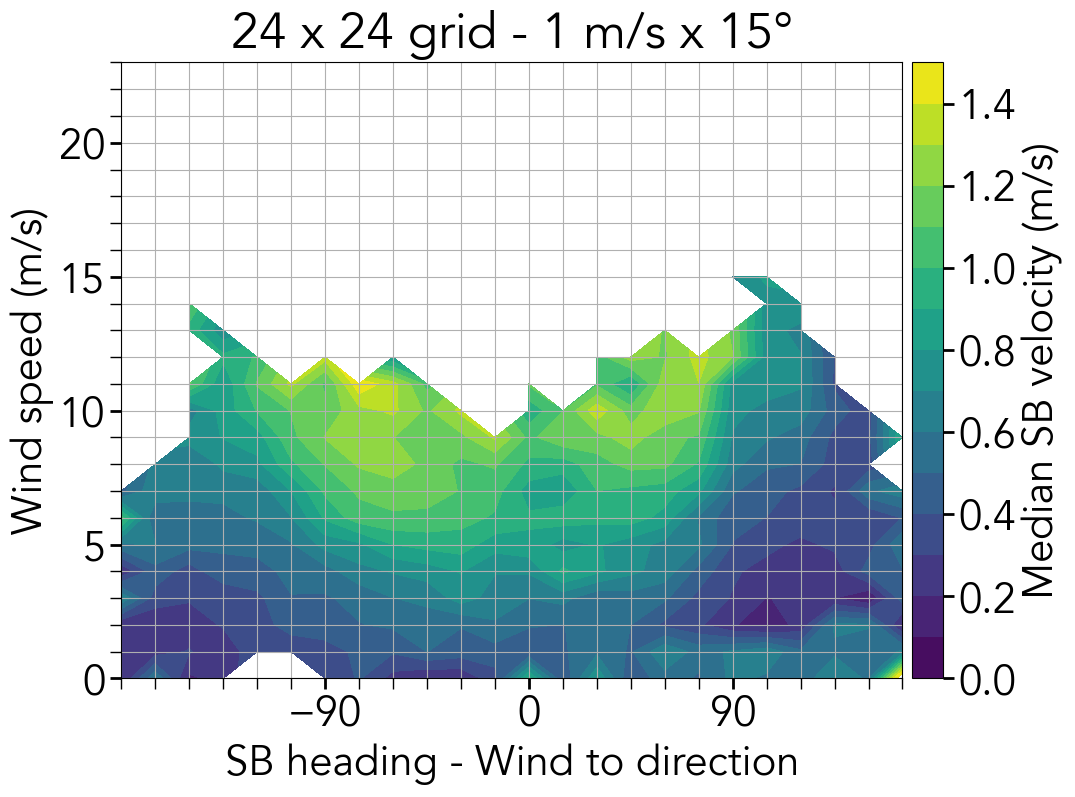

In [64]:
fig,ax = plt.subplots(figsize=(12,8))
ct = plt.contourf(np.arange(-180,180,15),np.arange(0,24,1),phil,levels=np.arange(0,1.6,0.1))
plt.colorbar(ct,label='Median SB velocity (m/s)',pad=0.01)
#plt.contour(np.arange(-180,180,15),np.arange(0,24,1),phil,levels=[0.5,1],colors='w')
plt.ylabel('Wind speed (m/s)')
plt.xlabel('SB heading - Wind to direction')
plt.title('24 x 24 grid - 1 m/s x 15°')
# plt.axvline(-90,c='w',ls='--')
# plt.axvline(-45,c='w',ls='--')
# plt.axvline(90,c='w',ls='--')
# plt.axvline(45,c='w',ls='--')
major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 101, 5)

ax.set_xticks(np.arange(-180, 180, 15), minor=True)
ax.set_xticks([-90,0,90])
ax.set_yticks(np.arange(0, 24, 1), minor=True)

# And a corresponding grid
ax.grid(which='both')

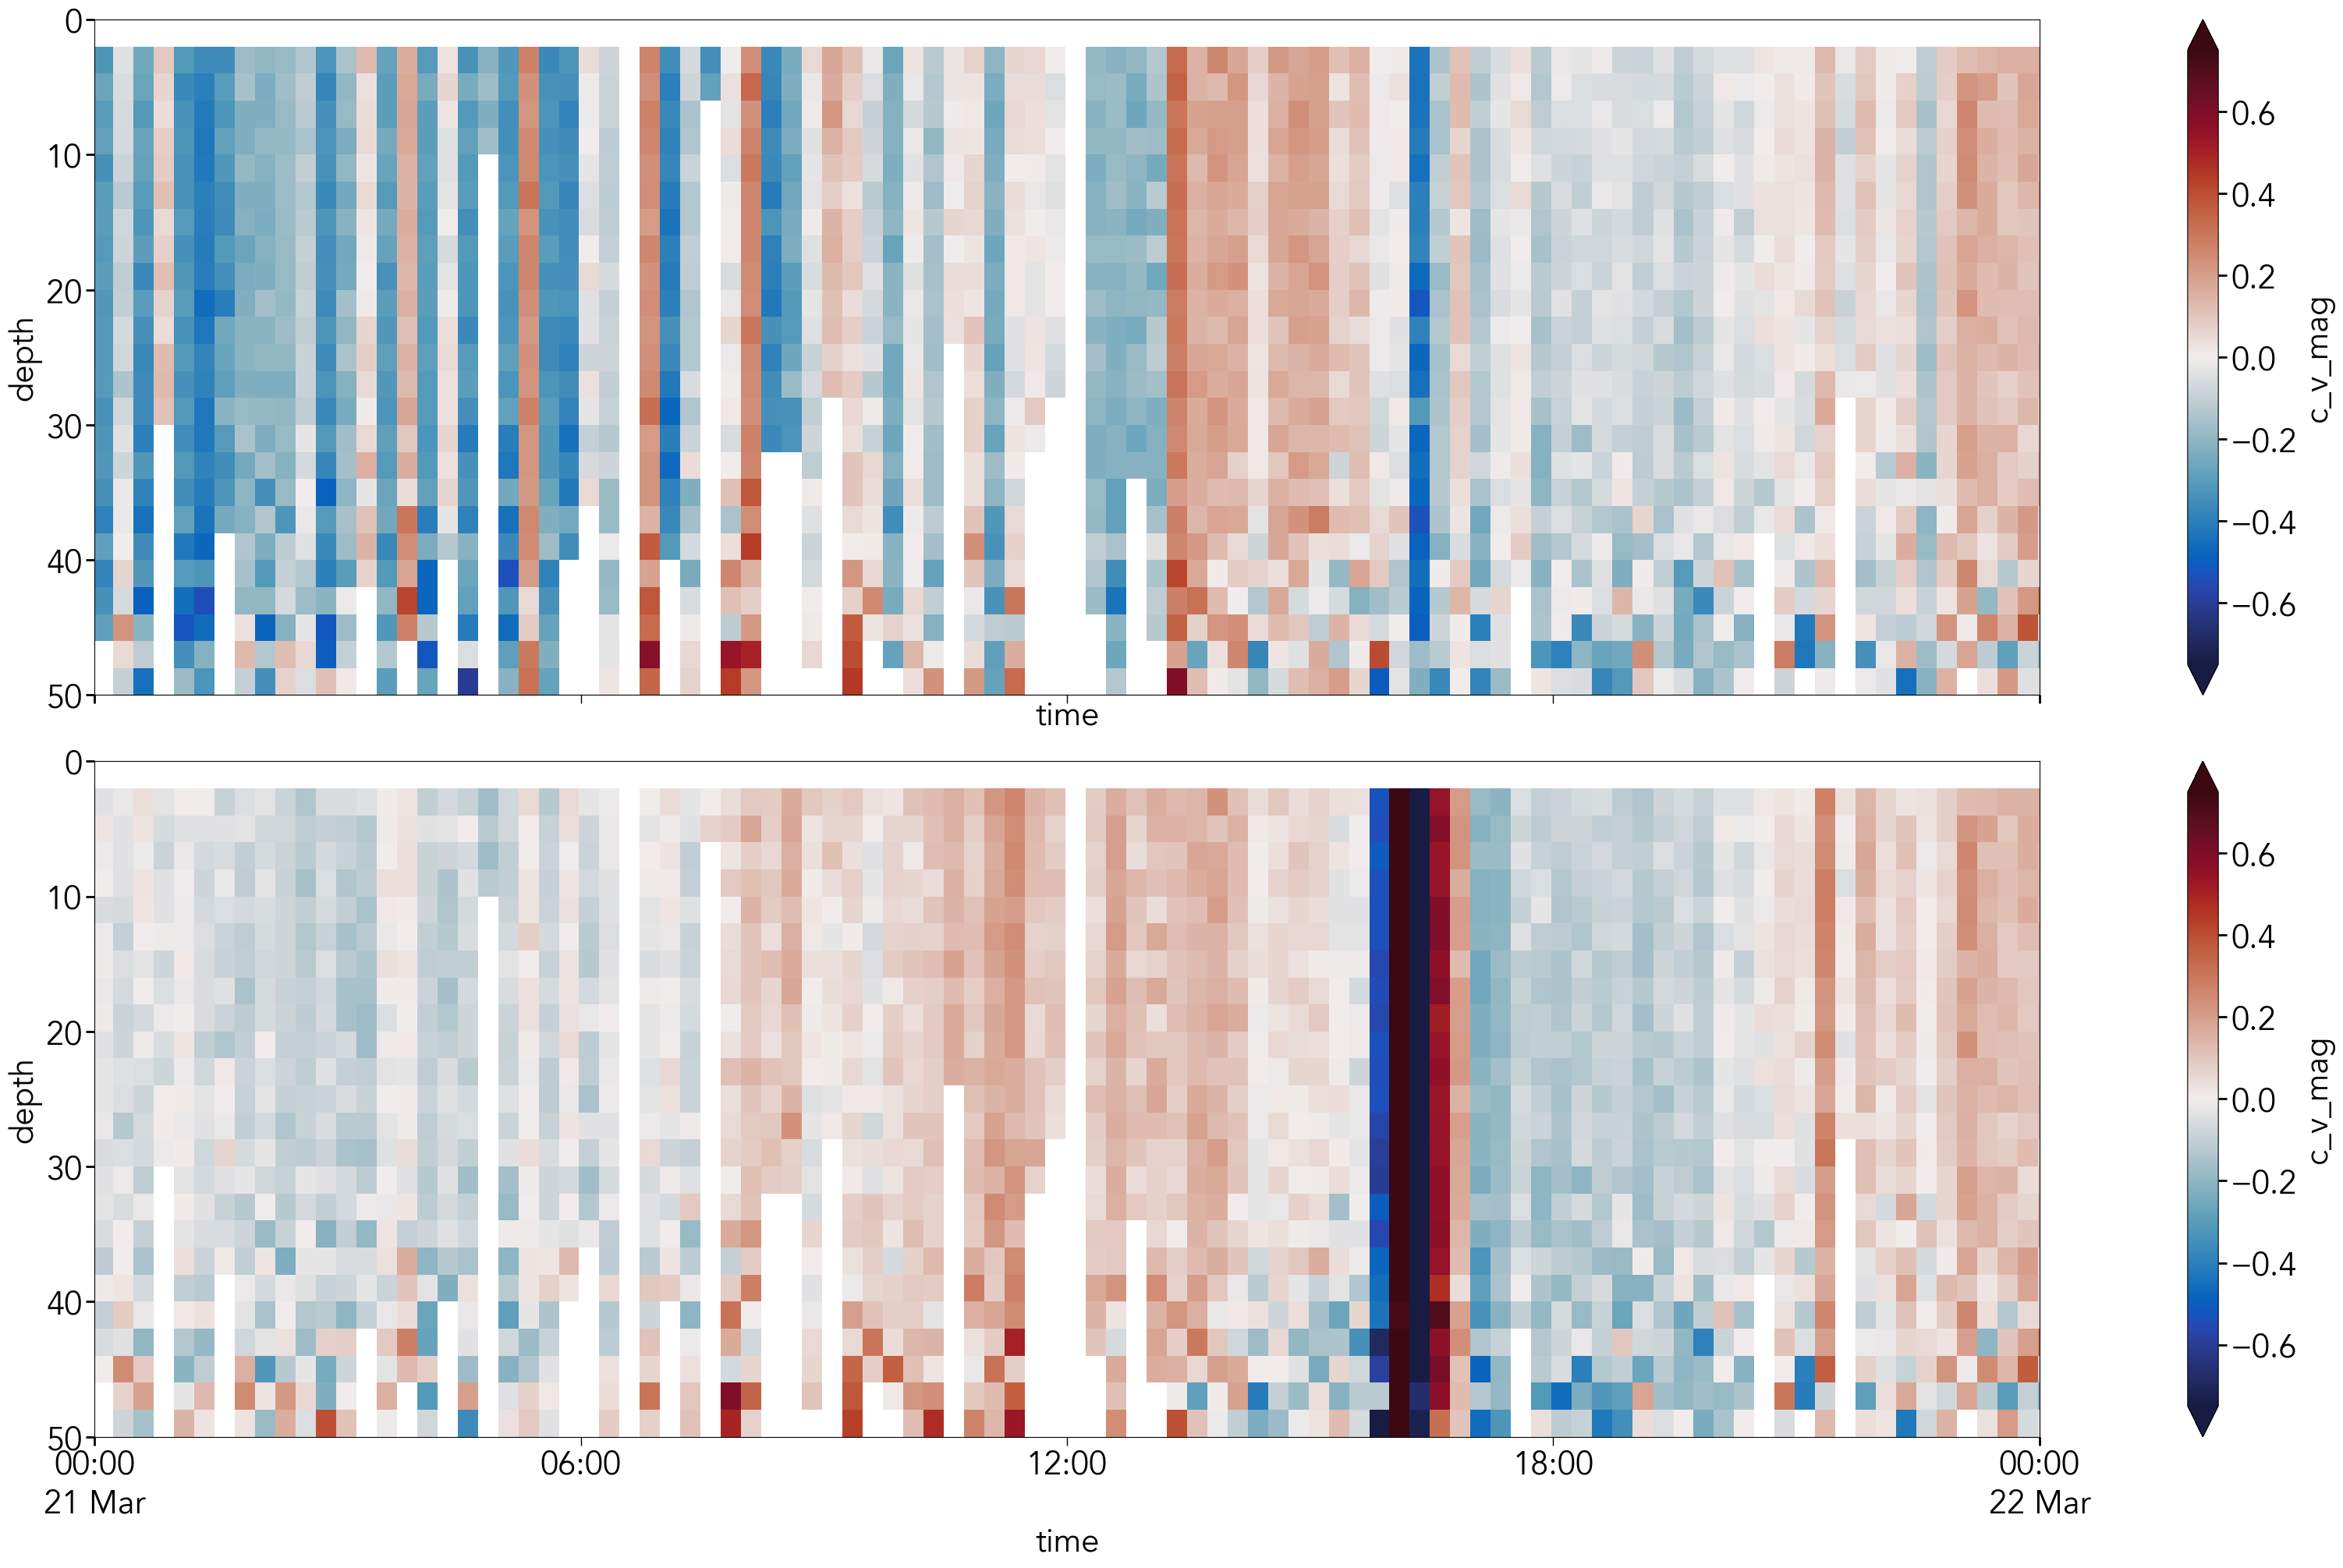

In [41]:
a = (ds['c_v_mag'] + (ds['sample_vel'].values * np.cos(np.deg2rad(ds['heading'].values))))
b = (ds['c_v_mag'] + (ds['sample_vel'].values * np.cos(np.deg2rad(ds['sample_heading'].values))))

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(30,20),constrained_layout=True,sharex=True)

a.plot(y='depth',ylim=(50,0),vmin=-0.75,vmax=0.75,ax=ax1,cmap=cmo.balance)
b.plot(y='depth',ylim=(50,0),vmin=-0.75,vmax=0.75,ax=ax2,cmap=cmo.balance)

ax2.set_xlim(np.datetime64('2022-03-21'),np.datetime64('2022-03-22'))
ax2.xaxis.set_minor_locator(mdates.HourLocator([0,6,12,18]))
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%d %b"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
rot_ticks(ax2,0,'center')